In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [5]:
import os
os.chdir("..")

In [6]:
from collections import defaultdict
from typing import List, Dict, Tuple, Optional, Union, Set

import click
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import expression
from ComplexTemporalQueryData import ICEWS05_15, ICEWS14, ComplexTemporalQueryDatasetCachePath, TemporalComplexQueryData, TYPE_train_queries_answers, GDELT
from ComplexTemporalQueryDataloader import TestDataset, TrainDataset
from expression.ParamSchema import is_entity, is_relation, is_timestamp
from expression.TFLEX_DSL import is_to_predict_entity_set, query_contains_union_and_we_should_use_DNF
from toolbox.data.dataloader import SingledirectionalOneShotIterator
from toolbox.exp.Experiment import Experiment
from toolbox.exp.OutputSchema import OutputSchema
from toolbox.utils.Progbar import Progbar
from toolbox.utils.RandomSeeds import set_seeds

In [7]:
QueryStructure = str
TYPE_token = Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]

L = 1

In [8]:
def convert_to_logic(x):
    # [0, 1]
    y = torch.sigmoid(2 * x)
    return y


def convert_to_feature(x):
    # [-1, 1]
    y = torch.tanh(x) * L
    return y


def convert_to_time_feature(x):
    # [-1, 1]
    y = torch.tanh(x) * L
    return y


def convert_to_time_logic(x):
    # [0, 1]
    y = torch.sigmoid(2 * x)
    return y

In [9]:
start_step= 0
max_steps= 300001
every_test_step= 10000
every_valid_step= 10000
batch_size= 512
test_batch_size= 8
negative_sample_size= 128
train_device= 'cuda:0'
test_device= 'cuda:0'
resume= True
resume_by_score= 0.0
lr= 0.0001
cpu_num= 1
hidden_dim= 800
input_dropout= 0.1
gamma= 30.0
center_reg= 0.02
dataset = "ICEWS14"
name = "TFLEX_dim800_gamma30"
data_home = "data"

In [10]:
set_seeds(0)
output = OutputSchema(dataset + "-" + name)

if dataset == "ICEWS14":
    dataset = ICEWS14(data_home)
elif dataset == "ICEWS05_15":
    dataset = ICEWS05_15(data_home)
elif dataset == "GDELT":
    dataset = GDELT(data_home)
cache = ComplexTemporalQueryDatasetCachePath(dataset.cache_path)
data = TemporalComplexQueryData(dataset, cache_path=cache)
data.preprocess_data_if_needed()

data already prepared, using cache


In [11]:
data.load_cache([
        "meta","all_timestamps","test_queries_answers"
    ])

In [12]:
data.test_queries_answers.keys()

dict_keys(['Pe', 'Pt', 'Pe2', 'Pe3', 'e2i', 'e3i', 'e2i_NPe', 'e2i_PeN', 'Pe_e2i_Pe_NPe', 'e2i_N', 'e3i_N', 'Pe_Pt', 'Pe_aPt', 'Pe_bPt', 'Pe_nPt', 't2i', 't3i', 'Pe_at2i', 'Pe_bt2i', 'Pe_nt2i', 'between', 't2i_NPt', 't2i_PtN', 'Pe_t2i_PtPe_NPt', 't2i_N', 't3i_N', 'e2i_Pe', 'Pe_e2i', 'e2u', 'Pe_e2u', 't2i_Pe', 'Pe_t2i', 't2u', 'Pe_t2u', 'aPt', 'bPt', 'Pt_sPe_Pt', 'Pt_oPe_Pt', 'Pt_se2i', 'Pt_oe2i', 'Pt_sPe', 'Pt_oPe'])

In [13]:
data.all_timestamps

['2014-01-01',
 '2014-01-02',
 '2014-01-03',
 '2014-01-04',
 '2014-01-05',
 '2014-01-06',
 '2014-01-07',
 '2014-01-08',
 '2014-01-09',
 '2014-01-10',
 '2014-01-11',
 '2014-01-12',
 '2014-01-13',
 '2014-01-14',
 '2014-01-15',
 '2014-01-16',
 '2014-01-17',
 '2014-01-18',
 '2014-01-19',
 '2014-01-20',
 '2014-01-21',
 '2014-01-22',
 '2014-01-23',
 '2014-01-24',
 '2014-01-25',
 '2014-01-26',
 '2014-01-27',
 '2014-01-28',
 '2014-01-29',
 '2014-01-30',
 '2014-01-31',
 '2014-02-01',
 '2014-02-02',
 '2014-02-03',
 '2014-02-04',
 '2014-02-05',
 '2014-02-06',
 '2014-02-07',
 '2014-02-08',
 '2014-02-09',
 '2014-02-10',
 '2014-02-11',
 '2014-02-12',
 '2014-02-13',
 '2014-02-14',
 '2014-02-15',
 '2014-02-16',
 '2014-02-17',
 '2014-02-18',
 '2014-02-19',
 '2014-02-20',
 '2014-02-21',
 '2014-02-22',
 '2014-02-23',
 '2014-02-24',
 '2014-02-25',
 '2014-02-26',
 '2014-02-27',
 '2014-02-28',
 '2014-03-01',
 '2014-03-02',
 '2014-03-03',
 '2014-03-04',
 '2014-03-05',
 '2014-03-06',
 '2014-03-07',
 '2014-03-

In [14]:

use_for_draw = data.test_queries_answers['Pt']['queries_answers']
print(use_for_draw[:10])

[([1426, 115, 3697], {}, {28}), ([1426, 6, 3697], {}, {325}), ([1426, 160, 3697], {}, {345}), ([1426, 160, 235], {}, {204}), ([1426, 38, 5373], {}, {180}), ([1426, 38, 1121], {}, {175}), ([1426, 156, 3697], {}, {80}), ([1426, 8, 2671], {}, {19}), ([5395, 56, 1077], {}, {135, 10, 90, 315, 316}), ([5395, 142, 711], {}, {121, 110})]


In [15]:
entity_count = data.entity_count
relation_count = data.relation_count
timestamp_count = data.timestamp_count
max_relation_id = relation_count
entity_count,relation_count,timestamp_count,max_relation_id

(7128, 230, 365, 230)

In [32]:

import gc
from collections import defaultdict
from typing import List, Dict, Tuple, Optional, Union, Set

import click
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import expression
from ComplexTemporalQueryData import ICEWS05_15, ICEWS14, GDELT, ComplexTemporalQueryDatasetCachePath, ComplexQueryData, TYPE_train_queries_answers, groups
from ComplexTemporalQueryDataloader import TestDataset, TrainDataset
from expression.ParamSchema import is_entity, is_relation, is_timestamp
from expression.TFLEX_DSL import is_to_predict_entity_set, query_contains_union_and_we_should_use_DNF
from toolbox.data.dataloader import SingledirectionalOneShotIterator
from toolbox.evaluate.GatherMetric import AverageMeter
from toolbox.exp.Experiment import Experiment
from toolbox.exp.OutputSchema import OutputSchema
from toolbox.utils.Progbar import Progbar
from toolbox.utils.RandomSeeds import set_seeds


QueryStructure = str
TYPE_token = Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]

L = 1


def convert_to_logic(x):
    # [0, 1]
    y = torch.sigmoid(2 * x)
    return y


def convert_to_feature(x):
    # [-1, 1]
    y = torch.tanh(x) * L
    return y


def convert_to_time_feature(x):
    # [-1, 1]
    y = torch.tanh(x) * L
    return y


def convert_to_time_logic(x):
    # [0, 1]
    y = torch.sigmoid(2 * x)
    return y


class EntityProjection(nn.Module):
    def __init__(self, dim, hidden_dim=800, num_layers=2, drop=0.1):
        super(EntityProjection, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(drop)
        token_dim = dim * 4
        self.layer1 = nn.Linear(token_dim, self.hidden_dim)
        self.layer0 = nn.Linear(self.hidden_dim, token_dim)
        for i in range(2, num_layers + 1):
            setattr(self, f"layer{i}", nn.Linear(self.hidden_dim, self.hidden_dim))
        for i in range(num_layers + 1):
            nn.init.xavier_uniform_(getattr(self, f"layer{i}").weight)

    def forward(self,
                q_feature, q_logic, q_time_feature, q_time_logic,
                r_feature, r_logic, r_time_feature, r_time_logic,
                t_feature, t_logic, t_time_feature, t_time_logic):
        x = torch.cat([
            q_feature + r_feature + t_feature,
            q_logic + r_logic + t_logic,
            q_time_feature + r_time_feature + t_time_feature,
            q_time_logic + r_time_logic + t_time_logic,
        ], dim=-1)
        for i in range(1, self.num_layers + 1):
            x = F.relu(getattr(self, f"layer{i}")(x))
        x = self.layer0(x)

        feature, logic, time_feature, time_logic = torch.chunk(x, 4, dim=-1)
        feature = convert_to_feature(feature)
        logic = convert_to_logic(logic)
        time_feature = convert_to_time_feature(time_feature)
        time_logic = convert_to_time_logic(time_logic)
        return feature, logic, time_feature, time_logic


class TimeProjection(nn.Module):
    def __init__(self, dim, hidden_dim=800, num_layers=2, drop=0.1):
        super(TimeProjection, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(drop)
        token_dim = dim * 4
        self.layer1 = nn.Linear(token_dim, self.hidden_dim)
        self.layer0 = nn.Linear(self.hidden_dim, token_dim)
        for nl in range(2, num_layers + 1):
            setattr(self, "layer{}".format(nl), nn.Linear(self.hidden_dim, self.hidden_dim))
        for nl in range(num_layers + 1):
            nn.init.xavier_uniform_(getattr(self, "layer{}".format(nl)).weight)

    def forward(self,
                q1_feature, q1_logic, q1_time_feature, q1_time_logic,
                r_feature, r_logic, r_time_feature, r_time_logic,
                q2_feature, q2_logic, q2_time_feature, q2_time_logic):
        x = torch.cat([
            q1_feature + r_feature + q2_feature,
            q1_logic + r_logic + q2_logic,
            q1_time_feature + r_time_feature + q2_time_feature,
            q1_time_logic + r_time_logic + q2_time_logic,
        ], dim=-1)
        for nl in range(1, self.num_layers + 1):
            x = F.relu(getattr(self, "layer{}".format(nl))(x))
        x = self.layer0(x)

        feature, logic, time_feature, time_logic = torch.chunk(x, 4, dim=-1)
        feature = convert_to_feature(feature)
        logic = convert_to_logic(logic)
        time_feature = convert_to_time_feature(time_feature)
        time_logic = convert_to_time_logic(time_logic)
        return feature, logic, time_feature, time_logic


class EntityIntersection(nn.Module):
    def __init__(self, dim):
        super(EntityIntersection, self).__init__()
        self.dim = dim
        self.feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.feature_layer_2 = nn.Linear(self.dim, self.dim)
        self.time_feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.time_feature_layer_2 = nn.Linear(self.dim, self.dim)

        nn.init.xavier_uniform_(self.feature_layer_1.weight)
        nn.init.xavier_uniform_(self.feature_layer_2.weight)
        nn.init.xavier_uniform_(self.time_feature_layer_1.weight)
        nn.init.xavier_uniform_(self.time_feature_layer_2.weight)

    def forward(self, feature, logic, time_feature, time_logic):
        # N x B x d
        logits = torch.cat([feature, logic], dim=-1)  # N x B x 2d
        feature_attention = F.softmax(self.feature_layer_2(F.relu(self.feature_layer_1(logits))), dim=0)
        feature = torch.sum(feature_attention * feature, dim=0)

        logits = torch.cat([time_feature, time_logic], dim=-1)  # N x B x 2d
        feature_attention = F.softmax(self.time_feature_layer_2(F.relu(self.time_feature_layer_1(logits))), dim=0)
        time_feature = torch.sum(feature_attention * time_feature, dim=0)

        logic, _ = torch.min(logic, dim=0)
        time_logic, _ = torch.min(time_logic, dim=0)
        return feature, logic, time_feature, time_logic


class TemporalIntersection(nn.Module):
    def __init__(self, dim):
        super(TemporalIntersection, self).__init__()
        self.dim = dim
        self.feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.feature_layer_2 = nn.Linear(self.dim, self.dim)
        self.time_feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.time_feature_layer_2 = nn.Linear(self.dim, self.dim)

        nn.init.xavier_uniform_(self.feature_layer_1.weight)
        nn.init.xavier_uniform_(self.feature_layer_2.weight)
        nn.init.xavier_uniform_(self.time_feature_layer_1.weight)
        nn.init.xavier_uniform_(self.time_feature_layer_2.weight)

    def forward(self, feature, logic, time_feature, time_logic):
        # N x B x d
        logits = torch.cat([feature, logic], dim=-1)  # N x B x 2d
        feature_attention = F.softmax(self.feature_layer_2(F.relu(self.feature_layer_1(logits))), dim=0)
        feature = torch.sum(feature_attention * feature, dim=0)

        logits = torch.cat([time_feature, time_logic], dim=-1)  # N x B x 2d
        feature_attention = F.softmax(self.time_feature_layer_2(F.relu(self.time_feature_layer_1(logits))), dim=0)
        time_feature = torch.sum(feature_attention * time_feature, dim=0)

        logic, _ = torch.min(logic, dim=0)
        time_logic, _ = torch.min(time_logic, dim=0)
        return feature, logic, time_feature, time_logic


class EntityNegation(nn.Module):
    def __init__(self, dim):
        super(EntityNegation, self).__init__()
        self.dim = dim
        self.feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.feature_layer_2 = nn.Linear(self.dim, self.dim)
        nn.init.xavier_uniform_(self.feature_layer_1.weight)
        nn.init.xavier_uniform_(self.feature_layer_2.weight)

    def forward(self, feature, logic, time_feature, time_logic):
        logits = torch.cat([feature, logic], dim=-1)  # N x B x 2d
        feature = self.feature_layer_2(F.relu(self.feature_layer_1(logits)))
        logic = 1 - logic
        return feature, logic, time_feature, time_logic


class TemporalNegation(nn.Module):
    def __init__(self, dim):
        super(TemporalNegation, self).__init__()
        self.dim = dim
        self.feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.feature_layer_2 = nn.Linear(self.dim, self.dim)
        nn.init.xavier_uniform_(self.feature_layer_1.weight)
        nn.init.xavier_uniform_(self.feature_layer_2.weight)

    def forward(self, feature, logic, time_feature, time_logic):
        logits = torch.cat([time_feature, time_logic], dim=-1)  # N x B x 2d
        time_feature = self.feature_layer_2(F.relu(self.feature_layer_1(logits)))
        time_logic = 1 - time_logic
        return feature, logic, time_feature, time_logic


def scale_feature(feature):
    # f,f' in [-L, L]
    # f' = (f + 2L) % (2L) - L, where L=1
    indicator_positive = feature >= 0
    indicator_negative = feature < 0
    feature[indicator_positive] = feature[indicator_positive] - L
    feature[indicator_negative] = feature[indicator_negative] + L
    return feature


class TemporalBefore(nn.Module):
    def __init__(self, dim):
        super(TemporalBefore, self).__init__()
        self.dim = dim

    def forward(self, feature, logic, time_feature, time_logic):
        time_feature = scale_feature(time_feature - L / 2 - time_logic / 2)
        time_logic = (L - time_logic) / 2

        return feature, logic, time_feature, time_logic


class TemporalAfter(nn.Module):
    def __init__(self, dim):
        super(TemporalAfter, self).__init__()
        self.dim = dim

    def forward(self, feature, logic, time_feature, time_logic):
        time_feature = scale_feature(time_feature + L / 2 + time_logic / 2)
        time_logic = (L - time_logic) / 2

        return feature, logic, time_feature, time_logic


class TemporalNext(nn.Module):
    def __init__(self):
        super(TemporalNext, self).__init__()

    def forward(self, feature, logic, time_feature, time_logic):
        time_feature = scale_feature(time_feature)
        time_logic = 1 - time_logic
        return feature, logic, time_feature, time_logic


class EntityUnion(nn.Module):
    def __init__(self, dim):
        super(EntityUnion, self).__init__()
        self.dim = dim
        self.feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.feature_layer_2 = nn.Linear(self.dim, self.dim)
        self.time_feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.time_feature_layer_2 = nn.Linear(self.dim, self.dim)

        nn.init.xavier_uniform_(self.feature_layer_1.weight)
        nn.init.xavier_uniform_(self.feature_layer_2.weight)
        nn.init.xavier_uniform_(self.time_feature_layer_1.weight)
        nn.init.xavier_uniform_(self.time_feature_layer_2.weight)

    def forward(self, feature, logic, time_feature, time_logic):
        # N x B x d
        logits = torch.cat([feature, logic], dim=-1)  # N x B x 2d
        feature_attention = F.softmax(self.feature_layer_2(F.relu(self.feature_layer_1(logits))), dim=0)
        feature = torch.sum(feature_attention * feature, dim=0)

        logits = torch.cat([time_feature, time_logic], dim=-1)  # N x B x 2d
        feature_attention = F.softmax(self.time_feature_layer_2(F.relu(self.time_feature_layer_1(logits))), dim=0)
        time_feature = torch.sum(feature_attention * time_feature, dim=0)

        logic, _ = torch.max(logic, dim=0)
        # for time, it is intersection
        time_logic, _ = torch.min(time_logic, dim=0)
        # logic = torch.prod(logic, dim=0)
        return feature, logic, time_feature, time_logic


class TemporalUnion(nn.Module):
    def __init__(self, dim):
        super(TemporalUnion, self).__init__()
        self.dim = dim
        self.feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.feature_layer_2 = nn.Linear(self.dim, self.dim)
        self.time_feature_layer_1 = nn.Linear(self.dim * 2, self.dim)
        self.time_feature_layer_2 = nn.Linear(self.dim, self.dim)

        nn.init.xavier_uniform_(self.feature_layer_1.weight)
        nn.init.xavier_uniform_(self.feature_layer_2.weight)
        nn.init.xavier_uniform_(self.time_feature_layer_1.weight)
        nn.init.xavier_uniform_(self.time_feature_layer_2.weight)

    def forward(self, feature, logic, time_feature, time_logic):
        # N x B x d
        logits = torch.cat([feature, logic], dim=-1)  # N x B x 2d
        feature_attention = F.softmax(self.feature_layer_2(F.relu(self.feature_layer_1(logits))), dim=0)
        feature = torch.sum(feature_attention * feature, dim=0)

        logits = torch.cat([time_feature, time_logic], dim=-1)  # N x B x 2d
        feature_attention = F.softmax(self.time_feature_layer_2(F.relu(self.time_feature_layer_1(logits))), dim=0)
        time_feature = torch.sum(feature_attention * time_feature, dim=0)

        # for entity, it is intersection
        logic, _ = torch.min(logic, dim=0)
        # for time, it is union
        time_logic, _ = torch.max(time_logic, dim=0)
        # logic = torch.prod(logic, dim=0)
        return feature, logic, time_feature, time_logic


class TFLEX(nn.Module):
    def __init__(self, nentity, nrelation, ntimestamp, hidden_dim, gamma,
                 test_batch_size=1,
                 center_reg=None, drop: float = 0.):
        super(TFLEX, self).__init__()
        self.nentity = nentity
        self.nrelation = nrelation
        self.hidden_dim = hidden_dim
        self.entity_dim = hidden_dim
        self.relation_dim = hidden_dim
        self.timestamp_dim = hidden_dim

        # entity only have feature part but no logic part
        self.entity_feature_embedding = nn.Embedding(nentity, self.entity_dim)

        self.timestamp_feature_embedding = nn.Embedding(ntimestamp, self.timestamp_dim)

        self.relation_feature_embedding = nn.Embedding(nrelation, self.relation_dim)
        self.relation_logic_embedding = nn.Embedding(nrelation, self.relation_dim)
        self.relation_time_feature_embedding = nn.Embedding(nrelation, self.relation_dim)
        self.relation_time_logic_embedding = nn.Embedding(nrelation, self.relation_dim)

        self.entity_projection = EntityProjection(hidden_dim, drop=drop)
        self.entity_intersection = EntityIntersection(hidden_dim)
        self.entity_union = EntityUnion(hidden_dim)
        self.entity_negation = EntityNegation(hidden_dim)

        self.time_projection = TimeProjection(hidden_dim, drop=drop)
        self.time_intersection = TemporalIntersection(hidden_dim)
        self.time_union = TemporalUnion(hidden_dim)
        self.time_negation = TemporalNegation(hidden_dim)
        self.time_before = TemporalBefore(hidden_dim)
        self.time_after = TemporalAfter(hidden_dim)
        self.time_next = TemporalNext()

        self.batch_entity_range = torch.arange(nentity).float().repeat(test_batch_size, 1)
        self.epsilon = 2.0
        self.gamma = nn.Parameter(torch.Tensor([gamma]), requires_grad=False)
        self.embedding_range = nn.Parameter(
            torch.Tensor([(self.gamma.item() + self.epsilon) / hidden_dim]),
            requires_grad=False)
        embedding_range = self.embedding_range.item()
        self.modulus = nn.Parameter(torch.Tensor([0.5 * embedding_range]), requires_grad=True)
        self.cen = center_reg
        self.parser = self.build_parser()

    def build_neural_ops(self):
        def And(q1, q2):
            q1_feature, q1_logic, q1_time_feature, q1_time_logic = q1
            q2_feature, q2_logic, q2_time_feature, q2_time_logic = q2
            feature = torch.stack([q1_feature, q2_feature])
            logic = torch.stack([q1_logic, q2_logic])
            time_feature = torch.stack([q1_time_feature, q2_time_feature])
            time_logic = torch.stack([q1_time_logic, q2_time_logic])
            return self.entity_intersection(feature, logic, time_feature, time_logic)

        def And3(q1, q2, q3):
            q1_feature, q1_logic, q1_time_feature, q1_time_logic = q1
            q2_feature, q2_logic, q2_time_feature, q2_time_logic = q2
            q3_feature, q3_logic, q3_time_feature, q3_time_logic = q3
            feature = torch.stack([q1_feature, q2_feature, q3_feature])
            logic = torch.stack([q1_logic, q2_logic, q3_logic])
            time_feature = torch.stack([q1_time_feature, q2_time_feature, q3_time_feature])
            time_logic = torch.stack([q1_time_logic, q2_time_logic, q3_time_logic])
            return self.entity_intersection(feature, logic, time_feature, time_logic)

        def Or(q1, q2):
            q1_feature, q1_logic, q1_time_feature, q1_time_logic = q1
            q2_feature, q2_logic, q2_time_feature, q2_time_logic = q2
            feature = torch.stack([q1_feature, q2_feature])
            logic = torch.stack([q1_logic, q2_logic])
            time_feature = torch.stack([q1_time_feature, q2_time_feature])
            time_logic = torch.stack([q1_time_logic, q2_time_logic])
            return self.entity_union(feature, logic, time_feature, time_logic)

        def Not(q):
            feature, logic, time_feature, time_logic = q
            return self.entity_negation(feature, logic, time_feature, time_logic)

        def TimeNot(q):
            feature, logic, time_feature, time_logic = q
            return self.time_negation(feature, logic, time_feature, time_logic)

        def EntityProjection2(e1, r1, t1):
            s_feature, s_logic, s_time_feature, s_time_logic = e1
            r_feature, r_logic, r_time_feature, r_time_logic = r1
            t_feature, t_logic, t_time_feature, t_time_logic = t1
            return self.entity_projection(
                s_feature, s_logic, s_time_feature, s_time_logic,
                r_feature, r_logic, r_time_feature, r_time_logic,
                t_feature, t_logic, t_time_feature, t_time_logic
            )

        def TimeProjection2(e1, r1, e2):
            s_feature, s_logic, s_time_feature, s_time_logic = e1
            r_feature, r_logic, r_time_feature, r_time_logic = r1
            o_feature, o_logic, o_time_feature, o_time_logic = e2
            return self.time_projection(
                s_feature, s_logic, s_time_feature, s_time_logic,
                r_feature, r_logic, r_time_feature, r_time_logic,
                o_feature, o_logic, o_time_feature, o_time_logic
            )

        def TimeAnd(q1, q2):
            q1_feature, q1_logic, q1_time_feature, q1_time_logic = q1
            q2_feature, q2_logic, q2_time_feature, q2_time_logic = q2
            feature = torch.stack([q1_feature, q2_feature])
            logic = torch.stack([q1_logic, q2_logic])
            time_feature = torch.stack([q1_time_feature, q2_time_feature])
            time_logic = torch.stack([q1_time_logic, q2_time_logic])
            return self.time_intersection(feature, logic, time_feature, time_logic)

        def TimeAnd3(q1, q2, q3):
            q1_feature, q1_logic, q1_time_feature, q1_time_logic = q1
            q2_feature, q2_logic, q2_time_feature, q2_time_logic = q2
            q3_feature, q3_logic, q3_time_feature, q3_time_logic = q3
            feature = torch.stack([q1_feature, q2_feature, q3_feature])
            logic = torch.stack([q1_logic, q2_logic, q3_logic])
            time_feature = torch.stack([q1_time_feature, q2_time_feature, q3_time_feature])
            time_logic = torch.stack([q1_time_logic, q2_time_logic, q3_time_logic])
            return self.time_intersection(feature, logic, time_feature, time_logic)

        def TimeOr(q1, q2):
            q1_feature, q1_logic, q1_time_feature, q1_time_logic = q1
            q2_feature, q2_logic, q2_time_feature, q2_time_logic = q2
            feature = torch.stack([q1_feature, q2_feature])
            logic = torch.stack([q1_logic, q2_logic])
            time_feature = torch.stack([q1_time_feature, q2_time_feature])
            time_logic = torch.stack([q1_time_logic, q2_time_logic])
            return self.time_union(feature, logic, time_feature, time_logic)

        def TimeBefore(q):
            feature, logic, time_feature, time_logic = q
            return self.time_before(feature, logic, time_feature, time_logic)

        def TimeAfter(q):
            feature, logic, time_feature, time_logic = q
            return self.time_after(feature, logic, time_feature, time_logic)

        def TimeNext(q):
            feature, logic, time_feature, time_logic = q
            return self.time_next(feature, logic, time_feature, time_logic)

        def beforePt(e1, r1, e2):
            return TimeBefore(TimeProjection2(e1, r1, e2))

        def afterPt(e1, r1, e2):
            return TimeAfter(TimeProjection2(e1, r1, e2))

        neural_ops = {
            "And": And,
            "And3": And3,
            "Or": Or,
            "Not": Not,
            "EntityProjection": EntityProjection2,
            "TimeProjection": TimeProjection2,
            "TimeAnd": TimeAnd,
            "TimeAnd3": TimeAnd3,
            "TimeOr": TimeOr,
            "TimeNot": TimeNot,
            "TimeBefore": TimeBefore,
            "TimeAfter": TimeAfter,
            "TimeNext": TimeNext,
            "afterPt": afterPt,
            "beforePt": beforePt,
        }
        return neural_ops

    def build_parser(self):
        neural_ops = self.build_neural_ops()
        return expression.NeuralParser(neural_ops)

    def init(self):
        embedding_range = self.embedding_range.item()
        nn.init.uniform_(tensor=self.entity_feature_embedding.weight.data, a=-embedding_range, b=embedding_range)

        nn.init.uniform_(tensor=self.timestamp_feature_embedding.weight.data, a=-embedding_range, b=embedding_range)

        nn.init.uniform_(tensor=self.relation_feature_embedding.weight.data, a=-embedding_range, b=embedding_range)
        nn.init.uniform_(tensor=self.relation_logic_embedding.weight.data, a=-embedding_range, b=embedding_range)
        nn.init.uniform_(tensor=self.relation_time_feature_embedding.weight.data, a=-embedding_range, b=embedding_range)
        nn.init.uniform_(tensor=self.relation_time_logic_embedding.weight.data, a=-embedding_range, b=embedding_range)

    def scale(self, embedding):
        return embedding / self.embedding_range

    def entity_feature(self, idx):
        return convert_to_feature(self.scale(self.entity_feature_embedding(idx)))

    def timestamp_feature(self, idx):
        return convert_to_time_feature(self.scale(self.timestamp_feature_embedding(idx)))

    def entity_token(self, idx) -> TYPE_token:
        feature = self.entity_feature(idx)
        logic = torch.zeros_like(feature).to(feature.device)
        time_feature = torch.zeros_like(feature).to(feature.device)
        time_logic = torch.zeros_like(feature).to(feature.device)
        return feature, logic, time_feature, time_logic

    def relation_token(self, idx) -> TYPE_token:
        feature = convert_to_feature(self.scale(self.relation_feature_embedding(idx)))
        logic = convert_to_logic(self.scale(self.relation_logic_embedding(idx)))
        time_feature = convert_to_time_feature(self.scale(self.relation_time_feature_embedding(idx)))
        time_logic = convert_to_time_logic(self.scale(self.relation_time_logic_embedding(idx)))
        return feature, logic, time_feature, time_logic

    def timestamp_token(self, idx) -> TYPE_token:
        time_feature = self.timestamp_feature(idx)
        feature = torch.zeros_like(time_feature).to(time_feature.device)
        logic = torch.zeros_like(feature).to(feature.device)
        time_logic = torch.zeros_like(feature).to(feature.device)
        return feature, logic, time_feature, time_logic

    def embed_args(self, query_args: List[str], query_tensor: torch.Tensor) -> TYPE_token:
        embedding_of_args = []
        for i in range(len(query_args)):
            arg_name = query_args[i]
            tensor = query_tensor[:, i]
            if is_entity(arg_name):
                token_embedding = self.entity_token(tensor)
            elif is_relation(arg_name):
                token_embedding = self.relation_token(tensor)
            elif is_timestamp(arg_name):
                token_embedding = self.timestamp_token(tensor)
            else:
                raise Exception("Unknown Args %s" % arg_name)
            embedding_of_args.append(token_embedding)
        return tuple(embedding_of_args)

    def forward(self, positive_sample, negative_sample, subsampling_weight, batch_queries_dict, batch_idxs_dict):
        return self.forward_FLEX(
            positive_sample, negative_sample, subsampling_weight, batch_queries_dict, batch_idxs_dict)

    def forward_FLEX(self,
                     positive_answer: Optional[torch.Tensor],
                     negative_answer: Optional[torch.Tensor],
                     subsampling_weight: Optional[torch.Tensor],
                     grouped_query: Dict[QueryStructure, torch.Tensor],
                     grouped_idxs: Dict[QueryStructure, List[List[int]]]):
        """
        positive_answer: None or (B, )
        negative_answer: None or (B, N)
        subsampling_weight: None or (B, )
        """
        # 1. 将 查询 嵌入到低维空间
        (all_idxs_e, all_predict_e), \
            (all_idxs_t, all_predict_t), \
            (all_union_idxs_e, all_union_predict_e), \
            (all_union_idxs_t, all_union_predict_t) = self.batch_predict(grouped_query, grouped_idxs)

        all_idxs = all_idxs_e + all_idxs_t + all_union_idxs_e + all_union_idxs_t
        if subsampling_weight is not None:
            subsampling_weight = subsampling_weight[all_idxs]

        positive_scores = None
        negative_scores = None

        # 2. 计算正例损失
        if positive_answer is not None:
            scores_e = self.scoring_to_answers_by_idxs(
                all_idxs_e, positive_answer, all_predict_e, predict_entity=True, DNF_predict=False)
            scores_t = self.scoring_to_answers_by_idxs(
                all_idxs_t, positive_answer, all_predict_t, predict_entity=False, DNF_predict=False)
            scores_union_e = self.scoring_to_answers_by_idxs(
                all_union_idxs_e, positive_answer, all_union_predict_e, predict_entity=True, DNF_predict=True)
            scores_union_t = self.scoring_to_answers_by_idxs(
                all_union_idxs_t, positive_answer, all_union_predict_t, predict_entity=False, DNF_predict=True)
            positive_scores = torch.cat([scores_e, scores_t, scores_union_e, scores_union_t], dim=0)

        # 3. 计算负例损失
        if negative_answer is not None:
            scores_e = self.scoring_to_answers_by_idxs(
                all_idxs_e, negative_answer, all_predict_e, predict_entity=True, DNF_predict=False)
            scores_t = self.scoring_to_answers_by_idxs(
                all_idxs_t, negative_answer, all_predict_t, predict_entity=False, DNF_predict=False)
            scores_union_e = self.scoring_to_answers_by_idxs(
                all_union_idxs_e, negative_answer, all_union_predict_e, predict_entity=True, DNF_predict=True)
            scores_union_t = self.scoring_to_answers_by_idxs(
                all_union_idxs_t, negative_answer, all_union_predict_t, predict_entity=False, DNF_predict=True)
            negative_scores = torch.cat([scores_e, scores_t, scores_union_e, scores_union_t], dim=0)

        return positive_scores, negative_scores, subsampling_weight, all_idxs

    def single_predict(self, query_structure: QueryStructure, query_tensor: torch.Tensor) -> Union[TYPE_token,
                                                                                                   Tuple[TYPE_token, TYPE_token]]:
        query_name, query_args = query_structure
        if query_contains_union_and_we_should_use_DNF(query_name):
            # transform to DNF
            func = self.parser.fast_function(query_name + "_DNF")
            embedding_of_args = self.embed_args(query_args, query_tensor)
            predict_1, predict_2 = func(*embedding_of_args)  # tuple[B x dt, B x dt]
            return predict_1, predict_2
        else:
            # other query and DM are normal
            func = self.parser.fast_function(query_name)
            embedding_of_args = self.embed_args(query_args, query_tensor)  # [B x dt]*L
            predict = func(*embedding_of_args)  # B x dt
            return predict

    def batch_predict(self, grouped_query: Dict[QueryStructure, torch.Tensor],
                      grouped_idxs: Dict[QueryStructure, List[List[int]]]):
        all_idxs_e, all_predict_e = [], []
        all_idxs_t, all_predict_t = [], []
        all_union_idxs_e, all_union_predict_1_e, all_union_predict_2_e = [], [], []
        all_union_idxs_t, all_union_predict_1_t, all_union_predict_2_t = [], [], []
        all_union_predict_e: Optional[TYPE_token] = None
        all_union_predict_t: Optional[TYPE_token] = None

        for query_structure in grouped_query:
            query_name = query_structure
            query_args = self.parser.fast_args(query_name)
            query_tensor = grouped_query[query_structure]  # (B, L), B for batch size, L for query args length
            query_idxs = grouped_idxs[query_structure]
            # query_idxs is of shape Bx1.
            # each element indicates global index of each row in query_tensor.
            # global index means the index in sample from dataloader.
            # the sample is grouped by query name and leads to query_tensor here.
            if query_contains_union_and_we_should_use_DNF(query_name):
                # transform to DNF
                func = self.parser.fast_function(query_name + "_DNF")
                embedding_of_args = self.embed_args(query_args, query_tensor)
                predict_1, predict_2 = func(*embedding_of_args)  # tuple[(B, d), (B, d)]
                if is_to_predict_entity_set(query_name):
                    all_union_predict_1_e.append(predict_1)
                    all_union_predict_2_e.append(predict_2)
                    all_union_idxs_e.extend(query_idxs)
                else:
                    all_union_predict_1_t.append(predict_1)
                    all_union_predict_2_t.append(predict_2)
                    all_union_idxs_t.extend(query_idxs)
            else:
                # other query and DM are normal
                func = self.parser.fast_function(query_name)
                embedding_of_args = self.embed_args(query_args, query_tensor)  # (B, d)*L
                predict = func(*embedding_of_args)  # (B, d)
                if is_to_predict_entity_set(query_name):
                    all_predict_e.append(predict)
                    all_idxs_e.extend(query_idxs)
                else:
                    all_predict_t.append(predict)
                    all_idxs_t.extend(query_idxs)

        def cat_to_tensor(token_list: List[TYPE_token]) -> TYPE_token:
            feature = []
            logic = []
            time_feature = []
            time_logic = []
            for x in token_list:
                feature.append(x[0])
                logic.append(x[1])
                time_feature.append(x[2])
                time_logic.append(x[3])
            feature = torch.cat(feature, dim=0).unsqueeze(1)
            logic = torch.cat(logic, dim=0).unsqueeze(1)
            time_feature = torch.cat(time_feature, dim=0).unsqueeze(1)
            time_logic = torch.cat(time_logic, dim=0).unsqueeze(1)
            return feature, logic, time_feature, time_logic

        if len(all_idxs_e) > 0:
            all_predict_e = cat_to_tensor(all_predict_e)  # (B, 1, d) * 5
        if len(all_idxs_t) > 0:
            all_predict_t = cat_to_tensor(all_predict_t)  # (B, 1, d) * 5
        if len(all_union_idxs_e) > 0:
            all_union_predict_1_e = cat_to_tensor(all_union_predict_1_e)  # (B, 1, d) * 5
            all_union_predict_2_e = cat_to_tensor(all_union_predict_2_e)  # (B, 1, d) * 5
            all_union_predict_e: TYPE_token = tuple([torch.cat([x, y], dim=1) for x, y in zip(
                all_union_predict_1_e, all_union_predict_2_e)])  # (B, 2, d) * 5
        if len(all_union_idxs_t) > 0:
            all_union_predict_1_t = cat_to_tensor(all_union_predict_1_t)  # (B, 1, d) * 5
            all_union_predict_2_t = cat_to_tensor(all_union_predict_2_t)  # (B, 1, d) * 5
            all_union_predict_t: TYPE_token = tuple([torch.cat([x, y], dim=1) for x, y in zip(
                all_union_predict_1_t, all_union_predict_2_t)])  # (B, 2, d) * 5
        return (all_idxs_e, all_predict_e), \
               (all_idxs_t, all_predict_t), \
               (all_union_idxs_e, all_union_predict_e), \
               (all_union_idxs_t, all_union_predict_t)

    def grouped_predict(self, grouped_query: Dict[QueryStructure, torch.Tensor],
                        grouped_answer: Dict[QueryStructure, torch.Tensor]) -> Dict[QueryStructure, torch.Tensor]:
        """
        return {"Pe": (B, L) }
        L 是答案个数，预测实体和预测时间戳 的答案个数不一样，所以不能对齐合并
        不同结构的 L 不同
        一般用于valid/test，不用于train
        """
        grouped_score = {}

        for query_structure in grouped_query:
            query = grouped_query[query_structure]  # (B, L), B for batch size, L for query args length
            answer = grouped_answer[query_structure]  # (B, N)
            grouped_score[query_structure] = self.forward_predict(query_structure, query, answer)

        return grouped_score

    def forward_predict(
            self, query_structure: QueryStructure, query_tensor: torch.Tensor, answer: torch.Tensor) -> torch.Tensor:
        # query_tensor  # (B, L), B for batch size, L for query args length
        # answer  # (B, N)
        query_name = query_structure
        query_args = self.parser.fast_args(query_name)
        # the sample is grouped by query name and leads to query_tensor here.
        if query_contains_union_and_we_should_use_DNF(query_name):
            # transform to DNF
            func = self.parser.fast_function(query_name + "_DNF")
            embedding_of_args = self.embed_args(query_args, query_tensor)
            predict_1, predict_2 = func(*embedding_of_args)  # tuple[(B, d), (B, d)]
            all_union_predict: TYPE_token = tuple([torch.stack([x, y], dim=1)
                                                  for x, y in zip(predict_1, predict_2)])  # (B, 2, d) * 5
            if is_to_predict_entity_set(query_name):
                return self.scoring_to_answers(answer, all_union_predict, predict_entity=True, DNF_predict=True)
            else:
                return self.scoring_to_answers(answer, all_union_predict, predict_entity=False, DNF_predict=True)
        else:
            # other query and DM are normal
            func = self.parser.fast_function(query_name)
            embedding_of_args = self.embed_args(query_args, query_tensor)  # (B, d)*L
            predict = func(*embedding_of_args)  # (B, d)
            all_predict: TYPE_token = tuple([i.unsqueeze(dim=1) for i in predict])  # (B, 1, d)
            if is_to_predict_entity_set(query_name):
                return self.scoring_to_answers(answer, all_predict, predict_entity=True, DNF_predict=False)
            else:
                return self.scoring_to_answers(answer, all_predict, predict_entity=False, DNF_predict=False)

    def scoring_to_answers_by_idxs(
            self, all_idxs, answer: torch.Tensor, q: TYPE_token, predict_entity=True, DNF_predict=False):
        """
        B for batch size
        N for negative sampling size (maybe N=1 when positive samples only)
        all_answer_idxs: (B, ) or (B, N) int
        all_predict:     (B, 1, dt) or (B, 2, dt) float
        return score:    (B, N) float
        """
        if len(all_idxs) <= 0:
            return torch.Tensor([]).to(self.embedding_range.device)
        answer_ids = answer[all_idxs]
        answer_ids = answer_ids.view(answer_ids.shape[0], -1)
        return self.scoring_to_answers(answer_ids, q, predict_entity, DNF_predict)

    def scoring_to_answers(self, answer_ids: torch.Tensor, q: TYPE_token, predict_entity=True, DNF_predict=False):
        """
        B for batch size
        N for negative sampling size (maybe N=1 when positive samples only)
        answer_ids:   (B, N) int
        all_predict:  (B, 1, dt) or (B, 2, dt) float
        return score: (B, N) float
        """
        q: TYPE_token = tuple([i.unsqueeze(dim=2) for i in q])  # (B, 1, 1, dt) or (B, 2, 1, dt)
        if predict_entity:
            feature = self.entity_feature(answer_ids).unsqueeze(dim=1)  # (B, 1, N, d)
            scores = self.scoring_entity(feature, q)  # (B, 1, N) or (B, 2, N)
        else:
            feature = self.timestamp_feature(answer_ids).unsqueeze(dim=1)  # (B, 1, N, d)
            scores = self.scoring_timestamp(feature, q)  # (B, 1, N) or (B, 2, N)

        if DNF_predict:
            scores = torch.max(scores, dim=1)[0]  # (B, N)
        else:
            scores = scores.squeeze(dim=1)  # (B, N)
        return scores  # (B, N)

    def distance_between_entity_and_query(self, entity_feature, query_feature, query_logic):
        """
        entity_feature (B, 1, N, d)
        query_feature  (B, 1, 1, dt) or (B, 2, 1, dt)
        query_logic    (B, 1, 1, dt) or (B, 2, 1, dt)
        query    =                 [(feature - logic) | feature | (feature + logic)]
        entity   = entity_feature            |             |               |
                         |                   |             |               |
        1) from entity to center of the interval           |               |
        d_center = entity_feature -                     feature            |
                         |<------------------------------->|               |
        2) from entity to left of the interval                             |
        d_left   = entity_feature - (feature - logic)                      |
                         |<----------------->|                             |
        3) from entity to right of the interval                            |
        d_right  = entity_feature -                               (feature + logic)
                         |<----------------------------------------------->|
        """
        d_center = entity_feature - query_feature
        d_left = entity_feature - (query_feature - query_logic)
        d_right = entity_feature - (query_feature + query_logic)

        # inner distance
        feature_distance = torch.abs(d_center)
        inner_distance = torch.min(feature_distance, query_logic)
        # outer distance
        outer_distance = torch.min(torch.abs(d_left), torch.abs(d_right))
        outer_distance[feature_distance < query_logic] = 0.  # if entity is inside, we don't care about outer.

        distance = torch.norm(outer_distance, p=1, dim=-1) + self.cen * torch.norm(inner_distance, p=1, dim=-1)
        return distance

    def distance_between_timestamp_and_query(self, timestamp_feature, time_feature, time_logic):
        """
        entity_feature (B, 1, N, d)
        query_feature  (B, 1, 1, dt) or (B, 2, 1, dt)
        query_logic    (B, 1, 1, dt) or (B, 2, 1, dt)
        query    =                 [(feature - logic) | feature | (feature + logic)]
        entity   = entity_feature            |             |               |
                         |                   |             |               |
        1) from entity to center of the interval           |               |
        d_center = entity_feature -                     feature            |
                         |<------------------------------->|               |
        2) from entity to left of the interval                             |
        d_left   = entity_feature - (feature - logic)                      |
                         |<----------------->|                             |
        3) from entity to right of the interval                            |
        d_right  = entity_feature -                               (feature + logic)
                         |<----------------------------------------------->|
        """
        d_center = timestamp_feature - time_feature
        d_left = timestamp_feature - (time_feature - time_logic)
        d_right = timestamp_feature - (time_feature + time_logic)

        # inner distance
        feature_distance = torch.abs(d_center)
        inner_distance = torch.min(feature_distance, time_logic)
        # outer distance
        outer_distance = torch.min(torch.abs(d_left), torch.abs(d_right))
        outer_distance[feature_distance < time_logic] = 0.  # if entity is inside, we don't care about outer.

        distance = torch.norm(outer_distance, p=1, dim=-1) + self.cen * torch.norm(inner_distance, p=1, dim=-1)
        return distance

    def scoring_entity(self, entity_feature, q: TYPE_token):
        feature, logic, time_feature, time_logic = q
        distance = self.distance_between_entity_and_query(entity_feature, feature, logic)
        score = self.gamma - distance * self.modulus
        return score

    def scoring_timestamp(self, timestamp_feature, q: TYPE_token):
        feature, logic, time_feature, time_logic = q
        distance = self.distance_between_timestamp_and_query(timestamp_feature, time_feature, time_logic)
        score = self.gamma - distance * self.modulus
        return score


In [33]:
model = TFLEX(
    nentity=entity_count,
    nrelation=relation_count + max_relation_id,  # with reverse relations
    ntimestamp=timestamp_count,
    hidden_dim=hidden_dim,
    gamma=gamma,
    center_reg=center_reg,
    test_batch_size=test_batch_size,
    drop=input_dropout,
).to(train_device)

In [34]:
from typing import Tuple

import torch
from torch import nn
from torch.optim import optimizer

from toolbox.exp.OutputSchema import OutputPathSchema

_MODEL_STATE_DICT = "model_state_dict"
_OPTIMIZER_STATE_DICT = "optimizer_state_dict"
_MODEL_STATE_DICT2 = "model_state_dict2"
_OPTIMIZER_STATE_DICT2 = "optimizer_state_dict2"
_EPOCH = "epoch"
_STEP = "step"
_BEST_SCORE = "best_score"
_LOSS = "loss"
def load_model(model: nn.Module, checkpoint_path="./result/fr_en/model.tar") -> float:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint[_MODEL_STATE_DICT])
    best_score = checkpoint[_BEST_SCORE]
    return best_score

In [35]:
checkpoint_path = '/home/linxueyuan/github/TFLEX/output/ICEWS14-TFLEX_dim800_gamma30/checkpoint/best_checkpoint.tar'

In [36]:
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
best_score = load_model(model=model, checkpoint_path=checkpoint_path)
best_score

0.3515559854307219

In [37]:
print(use_for_draw[:100])

[([1426, 115, 3697], {}, {28}), ([1426, 6, 3697], {}, {325}), ([1426, 160, 3697], {}, {345}), ([1426, 160, 235], {}, {204}), ([1426, 38, 5373], {}, {180}), ([1426, 38, 1121], {}, {175}), ([1426, 156, 3697], {}, {80}), ([1426, 8, 2671], {}, {19}), ([5395, 56, 1077], {}, {135, 10, 90, 315, 316}), ([5395, 142, 711], {}, {121, 110}), ([5395, 142, 3411], {}, {50}), ([5395, 142, 3347], {}, {115}), ([5395, 142, 4443], {}, {155}), ([5395, 142, 5389], {}, {157}), ([5395, 142, 5527], {}, {361}), ([5395, 142, 4805], {}, {129}), ([5395, 142, 6704], {}, {94}), ([5395, 142, 1221], {}, {41}), ([5395, 158, 711], {}, {114}), ([5395, 38, 2243], {}, {97}), ([5395, 38, 4283], {}, {106}), ([5395, 38, 1386], {}, {99}), ([5395, 38, 1503], {}, {294, 237, 82, 281, 346, 316, 350}), ([5395, 38, 6208], {}, {213}), ([5395, 38, 873], {}, {229}), ([5395, 38, 6847], {}, {221}), ([5395, 38, 4770], {}, {192}), ([5395, 207, 4721], {}, {177, 85}), ([5395, 207, 3922], {}, {305}), ([5395, 215, 1139], {}, {274}), ([5395, 16

In [38]:
device = 'cuda:0'
model.eval()
model.to(device)

TFLEX(
  (entity_feature_embedding): Embedding(7128, 800)
  (timestamp_feature_embedding): Embedding(365, 800)
  (relation_feature_embedding): Embedding(460, 800)
  (relation_logic_embedding): Embedding(460, 800)
  (relation_time_feature_embedding): Embedding(460, 800)
  (relation_time_logic_embedding): Embedding(460, 800)
  (entity_projection): EntityProjection(
    (dropout): Dropout(p=0.1, inplace=False)
    (layer1): Linear(in_features=3200, out_features=800, bias=True)
    (layer0): Linear(in_features=800, out_features=3200, bias=True)
    (layer2): Linear(in_features=800, out_features=800, bias=True)
  )
  (entity_intersection): EntityIntersection(
    (feature_layer_1): Linear(in_features=1600, out_features=800, bias=True)
    (feature_layer_2): Linear(in_features=800, out_features=800, bias=True)
    (time_feature_layer_1): Linear(in_features=1600, out_features=800, bias=True)
    (time_feature_layer_2): Linear(in_features=800, out_features=800, bias=True)
  )
  (entity_union):

In [39]:
import numpy as np
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range


def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

In [41]:
Pt = standardization(Pt)
Pt_before = standardization(Pt_before)
Pt_after = standardization(Pt_after)

NameError: name 'Pt' is not defined

In [40]:
Pt_before

NameError: name 'Pt_before' is not defined

In [295]:
Pt_after

array([-16.239635 , -16.364529 , -15.367672 , -16.899551 , -16.286709 ,
       -15.075039 , -15.199116 , -14.237865 , -15.19849  , -15.185131 ,
       -14.284786 , -15.001438 , -13.510017 , -13.533127 , -15.390778 ,
       -14.341167 , -14.738865 , -14.28574  , -16.295334 , -12.621418 ,
       -14.748417 , -16.353058 , -15.000004 , -15.126751 , -14.335495 ,
       -16.851097 , -14.202396 , -15.565517 , -15.40905  , -15.072208 ,
       -15.50407  , -12.304443 , -15.133743 , -13.615631 , -13.712154 ,
       -15.250698 , -13.413708 , -13.413654 , -13.925106 , -13.209293 ,
       -11.863155 , -14.955429 , -13.601753 , -13.925144 , -13.499512 ,
       -16.295498 , -14.354023 , -14.617798 , -14.801743 , -14.4917145,
       -14.030861 , -14.713921 , -14.553642 , -16.208675 , -14.759163 ,
       -15.934086 , -13.981163 , -14.397064 , -14.133724 , -17.869053 ,
       -13.651337 , -12.924774 , -13.106918 , -14.117817 , -14.944622 ,
       -15.588493 , -16.43282  , -16.169209 , -15.267456 , -13.6

In [296]:
Pt

array([ -6.2621193,  -2.2240715,   3.324295 ,  -4.085041 ,  -5.906002 ,
        -8.919708 ,  -7.890274 ,  -7.9073486,  -7.7601624,  -4.69289  ,
        -8.0913315,  -6.9221344,  -6.356579 ,  -6.3271294,  -8.3329735,
        -7.245949 ,  -8.0656395,  -6.136589 ,  -5.988121 ,  -8.138191 ,
       -12.145401 ,  -8.831554 ,  -8.17234  ,  -7.6162224,  -4.324074 ,
        -7.995983 ,  -4.9748955, -11.645073 ,  -3.055458 ,  -9.148682 ,
        -9.630695 ,  -7.045372 , -11.923145 ,  -8.456135 ,  -5.458027 ,
        -8.101578 ,  -8.997707 ,  -8.782082 ,  -6.6558037,  -4.0519066,
        -4.970276 ,  -3.2372246,  -2.8536224,  -3.4954987,  -8.8448105,
       -10.347858 ,  -5.1231575,   5.066618 ,  -4.3886795,  -7.0386963,
       -10.123108 ,  -7.273201 ,  -6.0824547,  -6.30867  ,  -4.085575 ,
        -5.1557007, -11.663712 ,  -7.6573677,  -4.6092415, -11.727604 ,
        -9.596573 ,  -9.095306 ,  -8.91386  ,  -8.225723 ,  -5.4379272,
        -9.048893 , -10.976345 ,  -8.963787 ,  -9.0029335,  -8.2

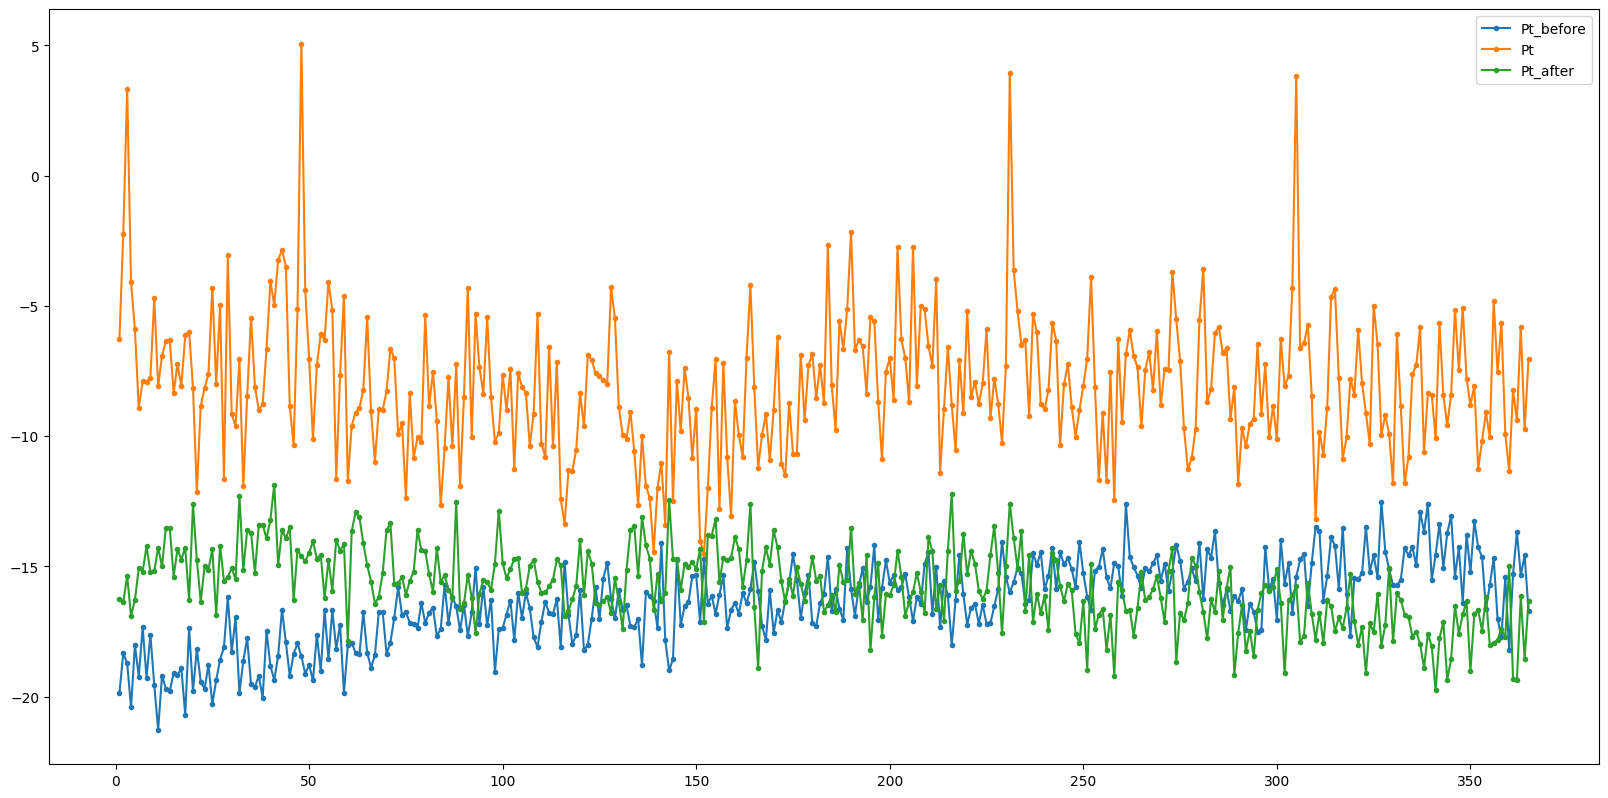

In [321]:

import matplotlib.pyplot as plt


plt.figure(figsize=(20, 10), dpi=100)
x = range(1,366)
y1 = Pt_before
y2 = Pt
y3 = Pt_after
plt.plot(x, y1, marker='o', markersize=3)
plt.plot(x, y2, marker='o', markersize=3)
plt.plot(x, y3, marker='o', markersize=3)
plt.legend(['Pt_before', 'Pt', 'Pt_after'])  # 设置折线名称
plt.show()


In [105]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline

def draw(id):
    query = use_for_draw[id][0]
    print(query)
    grouped_query = {
        "TimeProjection": torch.LongTensor([
            query
        ]),
        "bPt": torch.LongTensor([
            query
        ]),
        "aPt": torch.LongTensor([
            query
        ])
    }
    grouped_candidate_answer = {
        "TimeProjection": torch.LongTensor(range(timestamp_count)),
        "bPt": torch.LongTensor(range(timestamp_count)),
        "aPt": torch.LongTensor(range(timestamp_count))
    }

    for query_name in grouped_query:
        grouped_query[query_name] = grouped_query[query_name].to(device)
        grouped_candidate_answer[query_name] = grouped_candidate_answer[query_name].to(device)

    grouped_score = model.grouped_predict(grouped_query, grouped_candidate_answer)

    Pt = grouped_score['TimeProjection'].squeeze()
    Pt_before = grouped_score['bPt'].squeeze()
    Pt_after = grouped_score['aPt'].squeeze()
#     Pt = -Pt
#     Pt_before = -Pt_before
#     Pt_after = -Pt_after
    Pt = Pt.cpu().detach().numpy()
    Pt_before = Pt_before.cpu().detach().numpy()
    Pt_after = Pt_after.cpu().detach().numpy()
    norm_max = max(np.max(Pt_before), np.max(Pt), np.max(Pt_after))
    norm_min = min(np.min(Pt_before), np.min(Pt), np.min(Pt_after))
    norm_ran = norm_max - norm_min
    Pt = (Pt - norm_min) / norm_ran
    Pt_before = (Pt_before - norm_min) / norm_ran
    Pt_after = (Pt_after - norm_min) / norm_ran

    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6), dpi=100)



    x = np.array(list(range(1,366)))
    y1 = Pt_before
    y2 = Pt
    y3 = Pt_after
    nx = np.linspace(x.min(),x.max(),50)
    ny1 = make_interp_spline(x,y1)(nx)
    ny2 = make_interp_spline(x,y2)(nx)
    ny3 = make_interp_spline(x,y3)(nx)

    ny1 = make_interp_spline(x,y1)(nx)
    ny2 = make_interp_spline(x,y2)(nx)
    ny3 = make_interp_spline(x,y3)(nx)

    plt.plot(nx, ny1, linewidth=3)
    plt.plot(nx, ny2, linewidth=3)
    plt.plot(nx, ny3, linewidth=3)

    plt.axvline(0, color='black', linestyle ="--",)
    plt.axvline(50, color='black', linestyle ="--",)
    plt.fill_between(x[0:50], 0, 1, facecolor='blue', alpha=0.3)

    plt.axvline(158, color='black', linestyle ="--",)
    plt.axvline(196, color='black', linestyle ="--",)
    plt.fill_between(x[157:196], 0, 1, facecolor='orange', alpha=0.3)

    plt.axvline(280, color='black', linestyle ="--",)
    plt.axvline(350, color='black', linestyle ="--",)
    plt.fill_between(x[279:350], 0, 1, facecolor='green', alpha=0.3)

    plt.legend(['bPt=$\mathcal{B}_t(\mathcal{P}_t(s,r,o))$', 'Pt=$\mathcal{P}_t(s,r,o)$', 'aPt=$\mathcal{A}_t(\mathcal{P}_t(s,r,o))$'])  # 设置折线名称
    plt.xlabel('Time')
    plt.ylabel('Score')
    # plt.xlim((0, 365))
    plt.ylim((0, 1))
    plt.show()
#     plt.save('before_after.png')

[5395, 53, 6635]


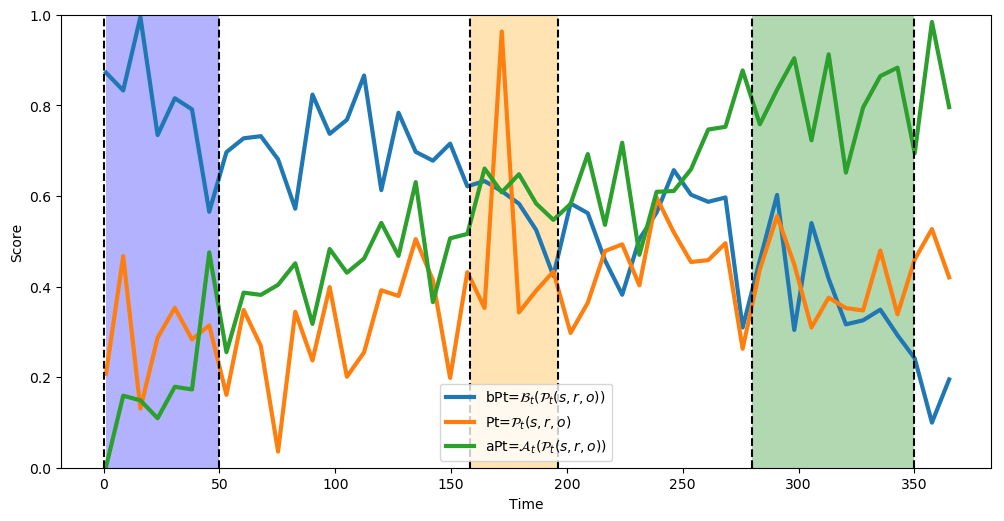

In [186]:
draw(37)

[4702, 22, 6823] {} {103}
Mohammad Javad Zarif
Appeal for economic cooperation
United Arab Emirates
['2014-04-14']


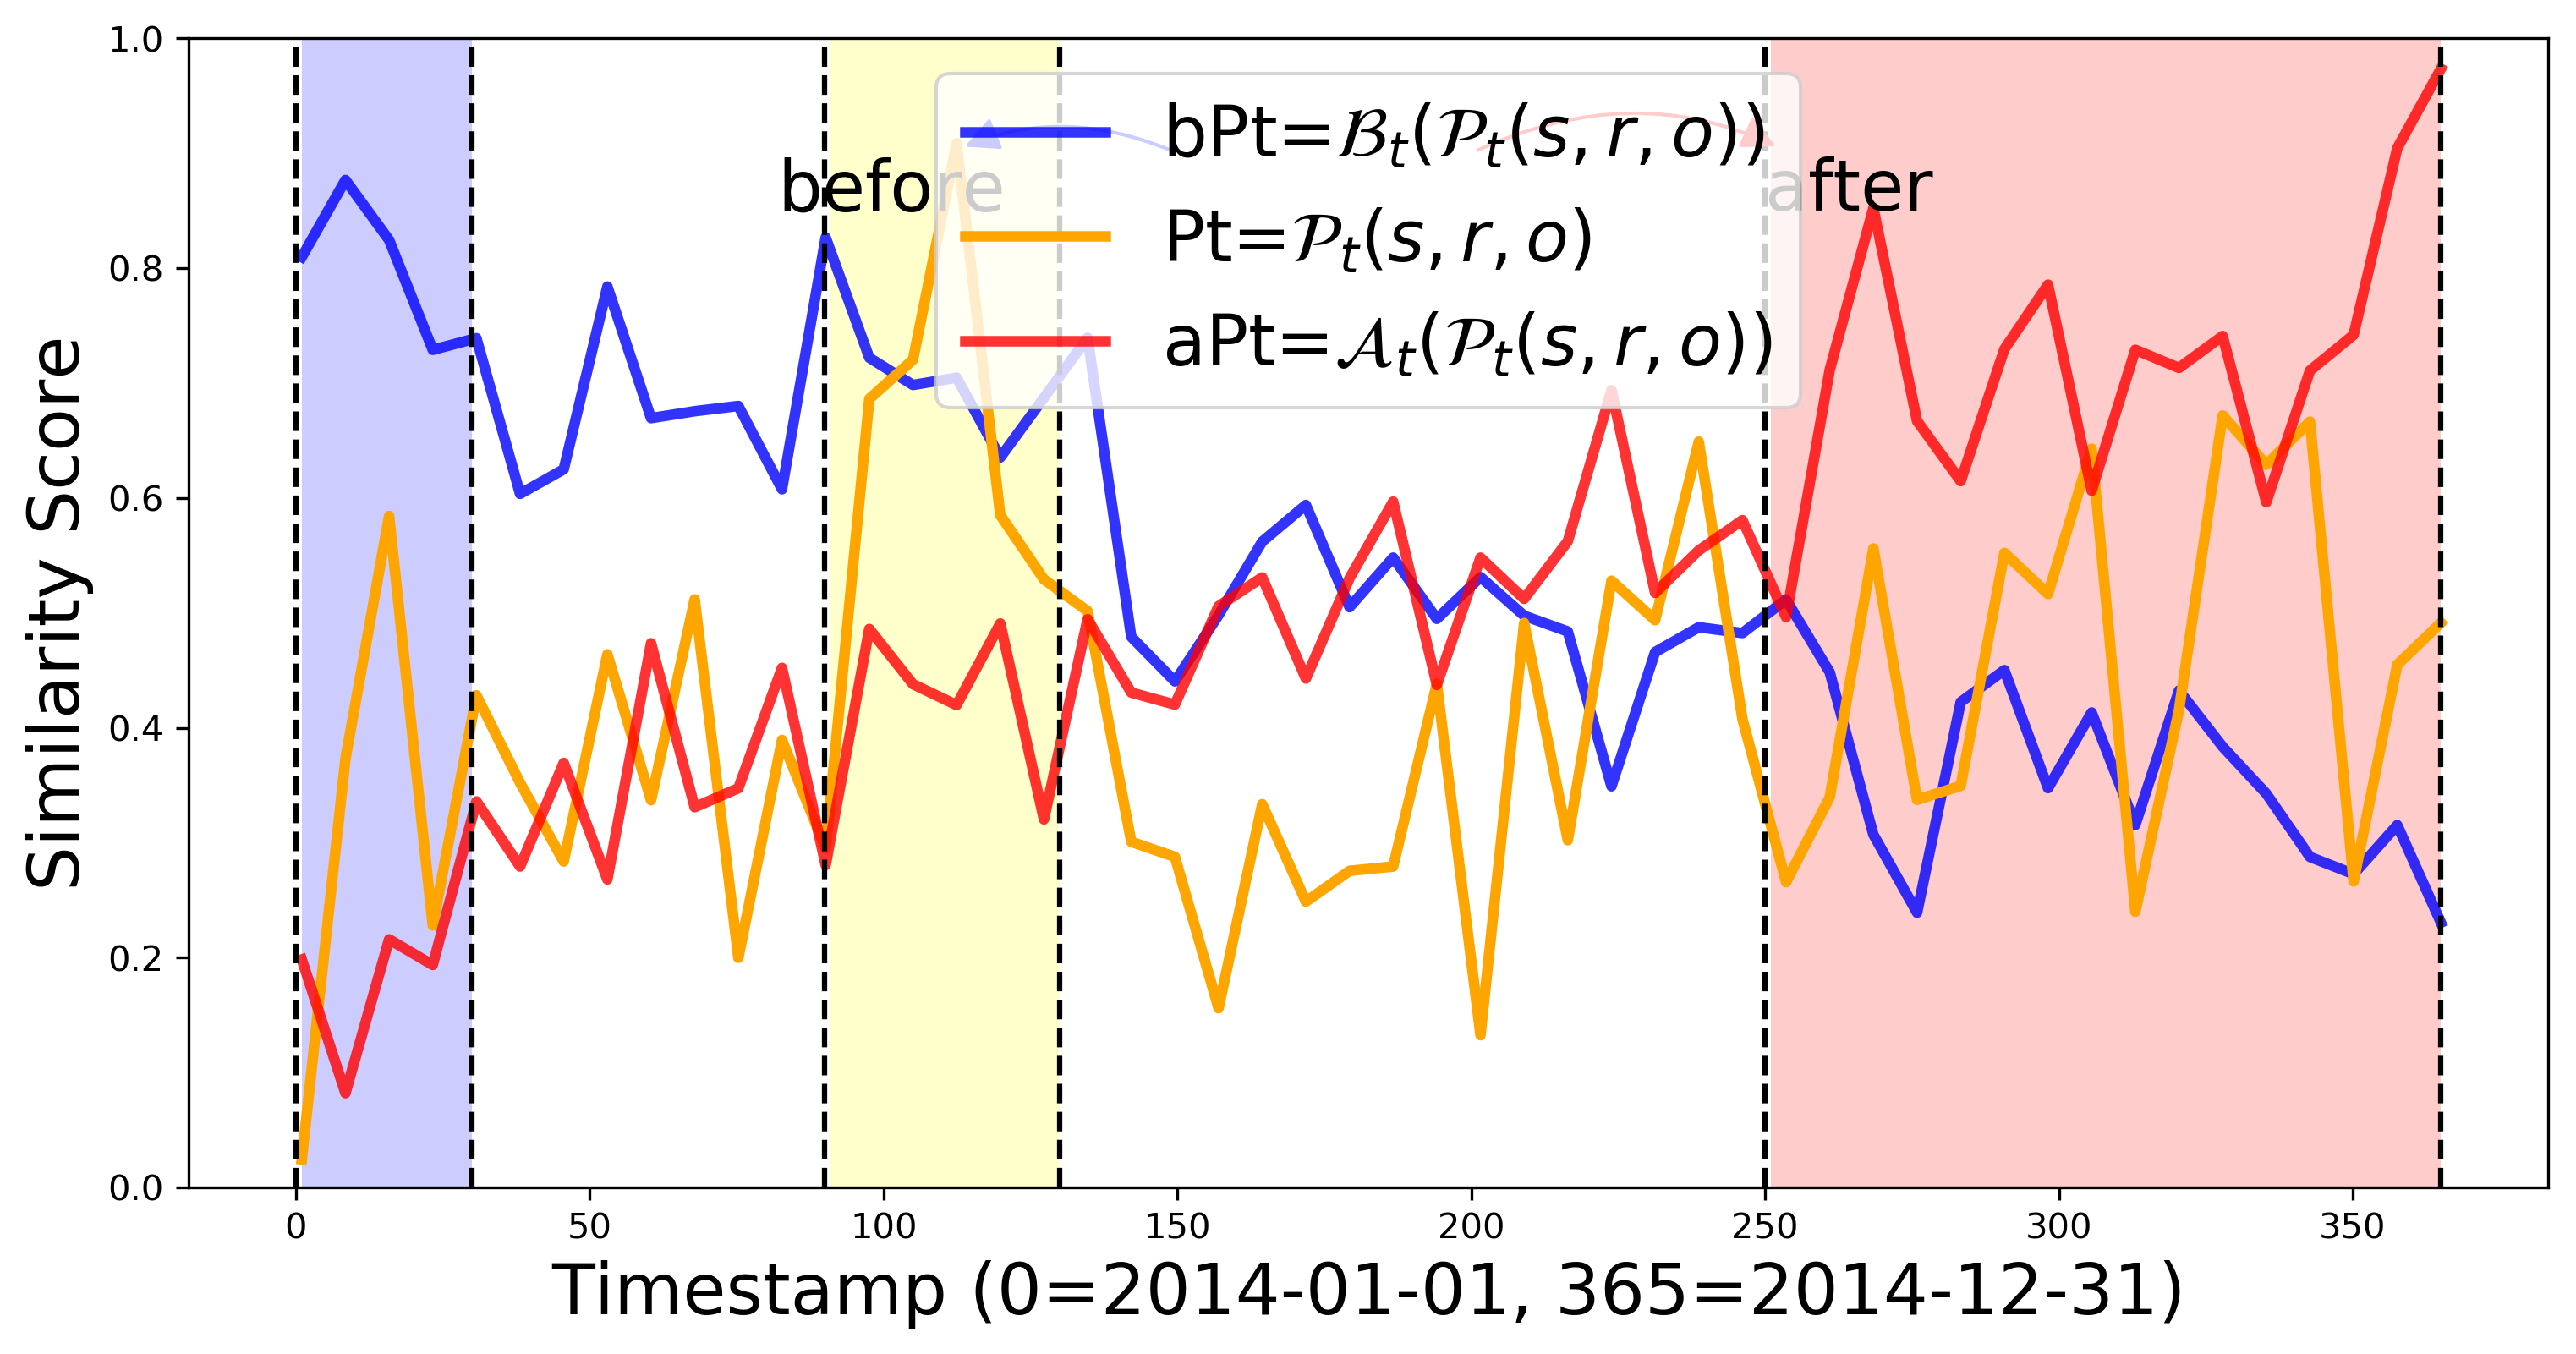

In [326]:
draw(68, 'before_after4.png', (0,30), (90, 130), (250, 365))

[1145, 56, 6109] {} {85}
Citizen (India)
Criticize or denounce
Sadhu (India)
['2014-03-27']


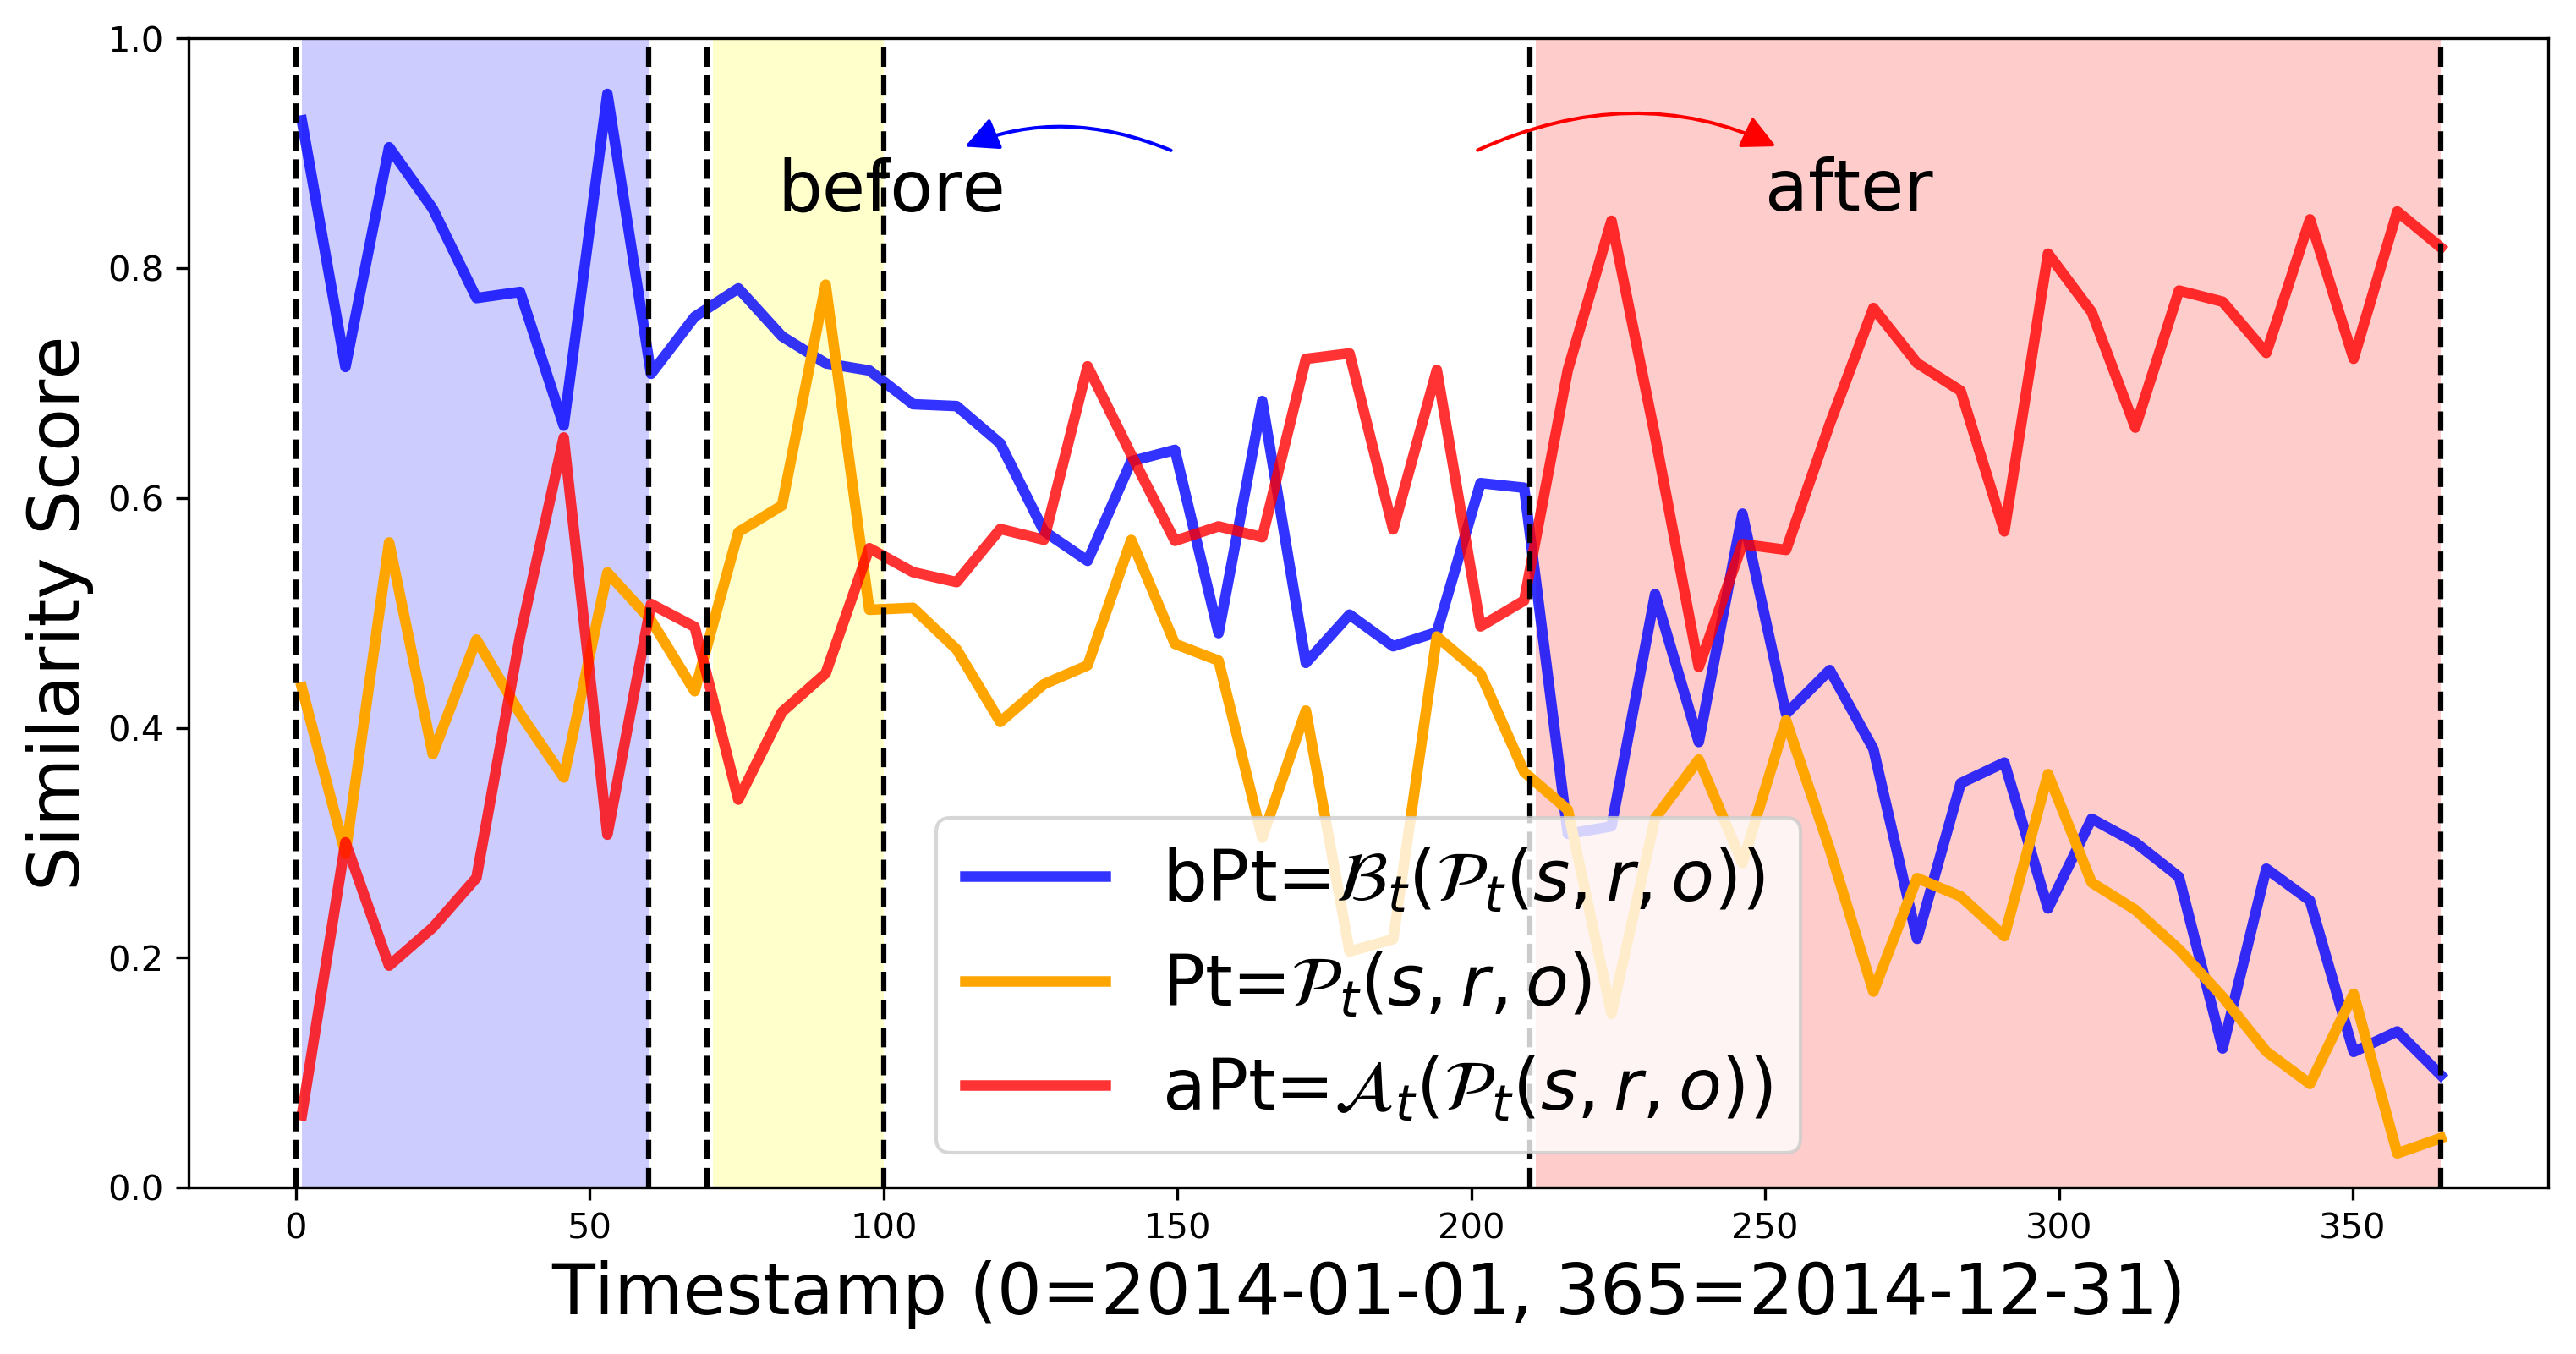

In [322]:
draw(132, 'before_after3.png', (0,60), (70, 100), (210, 365))

[1145, 56, 1928] {} {131}
Citizen (India)
Criticize or denounce
Election Commission (India)
['2014-05-12']


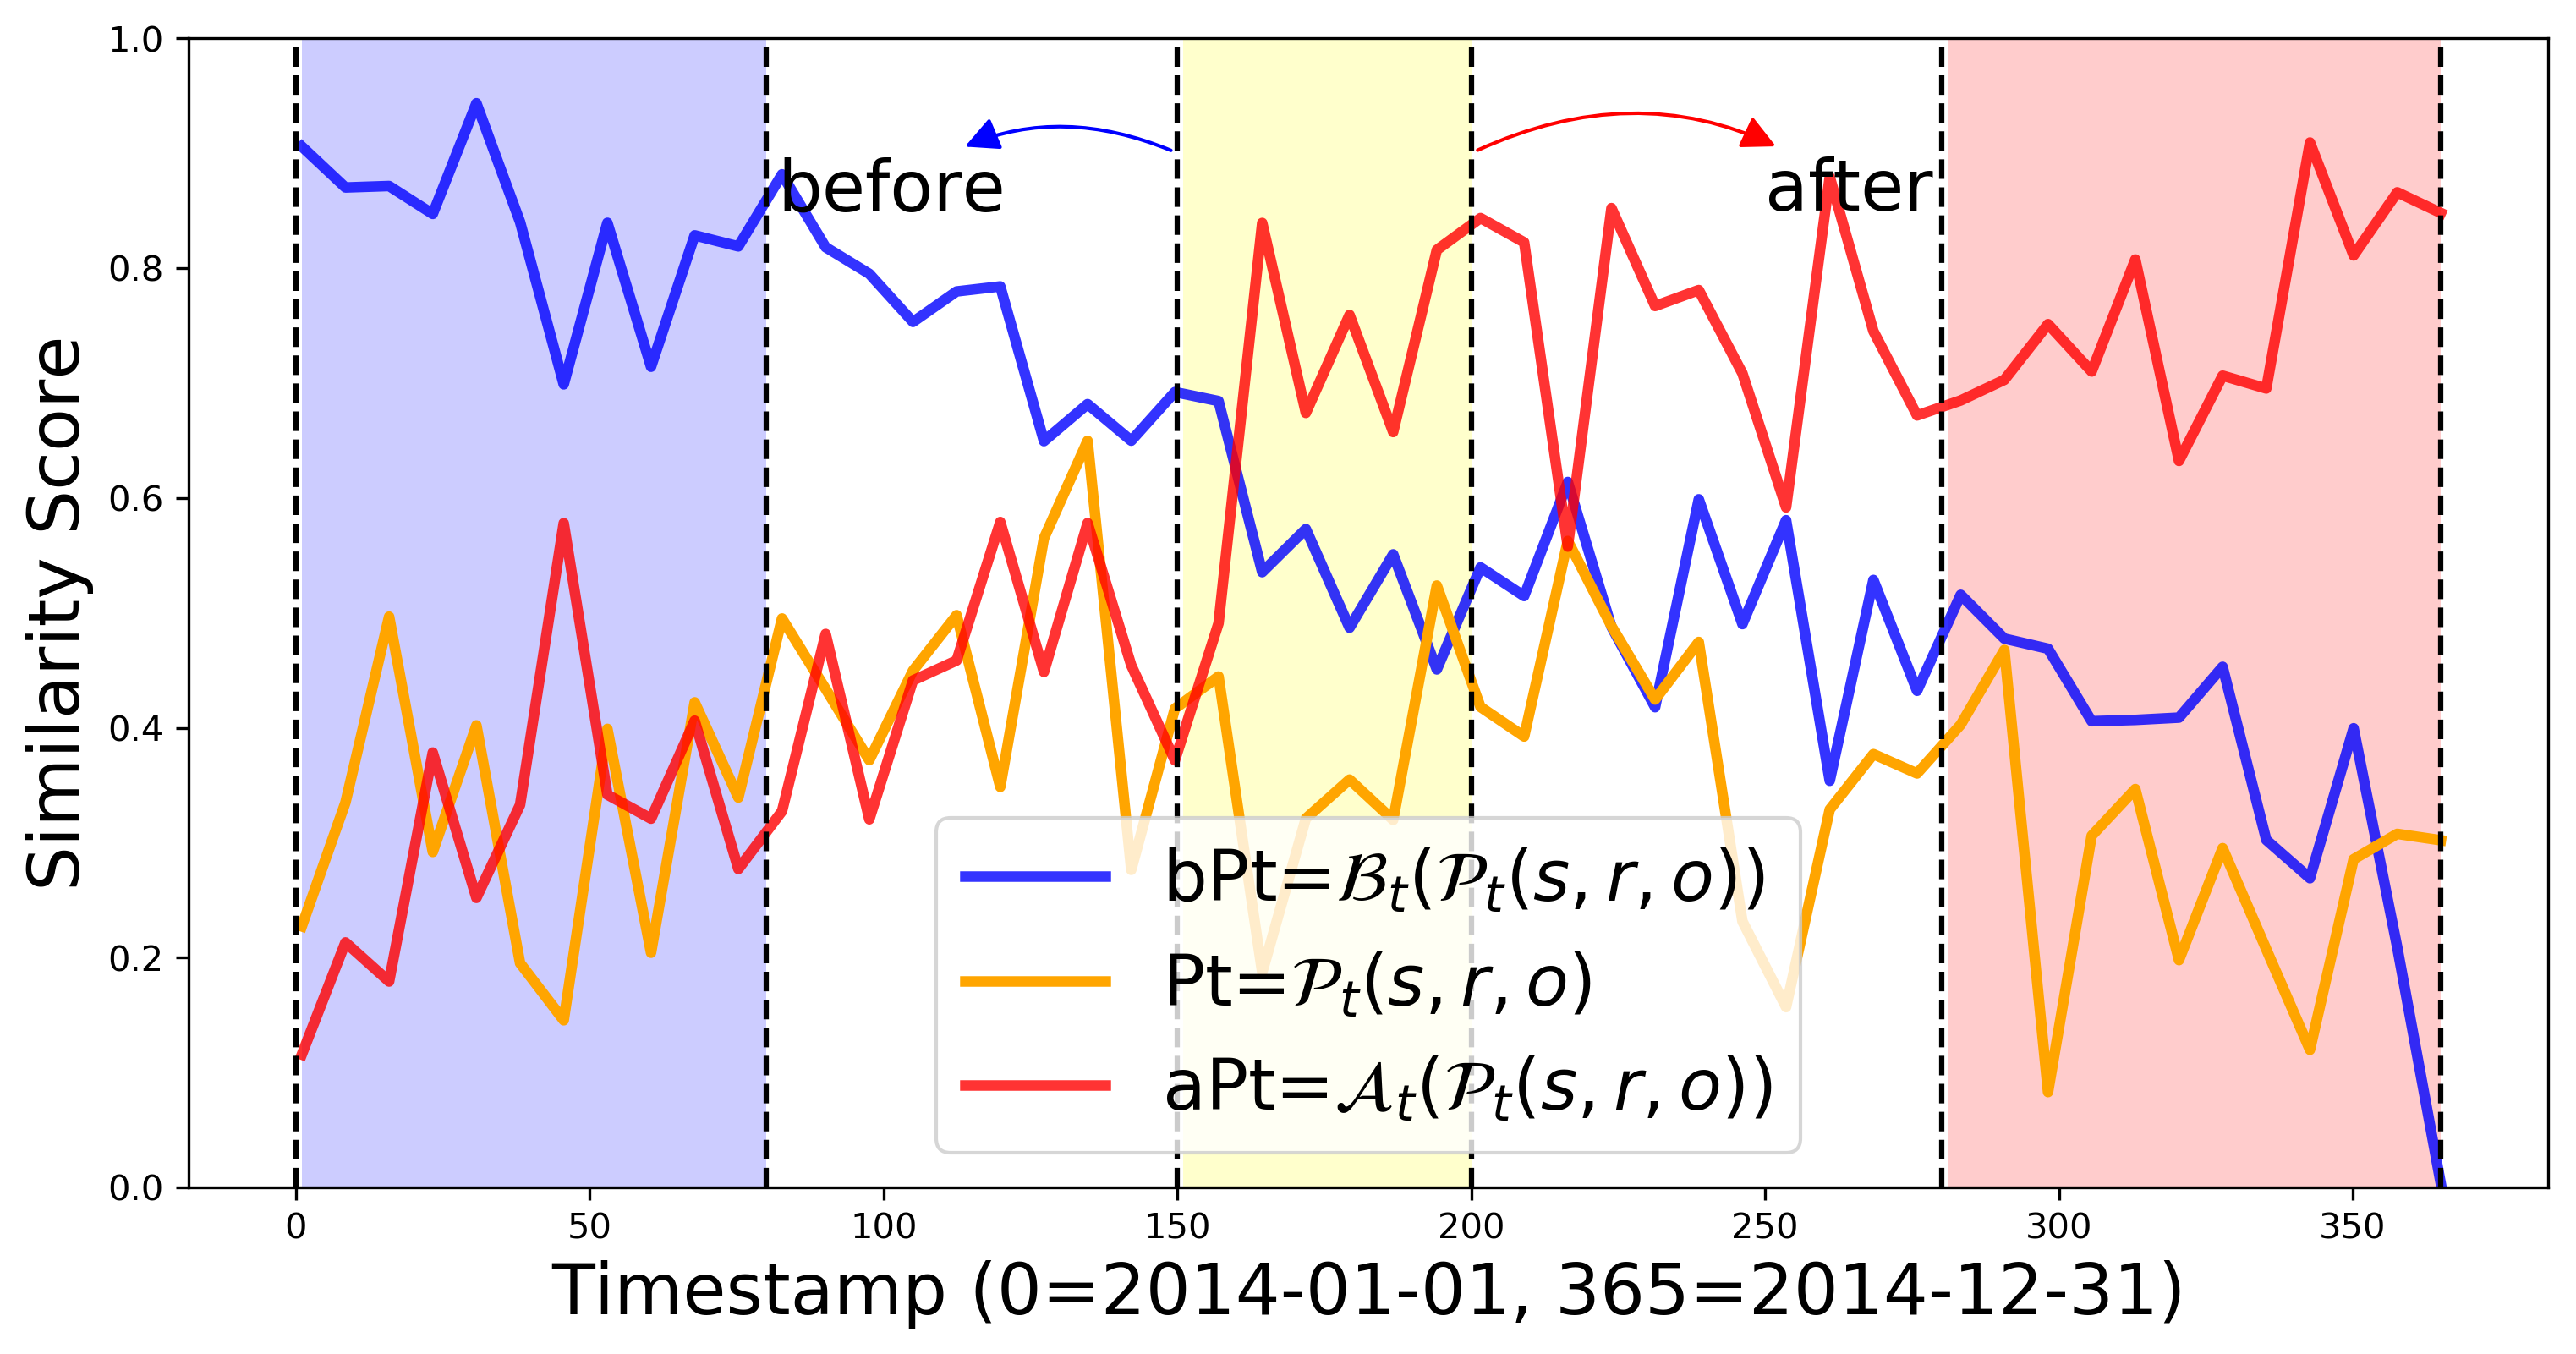

In [327]:
draw(140)

[1145, 156, 1691]


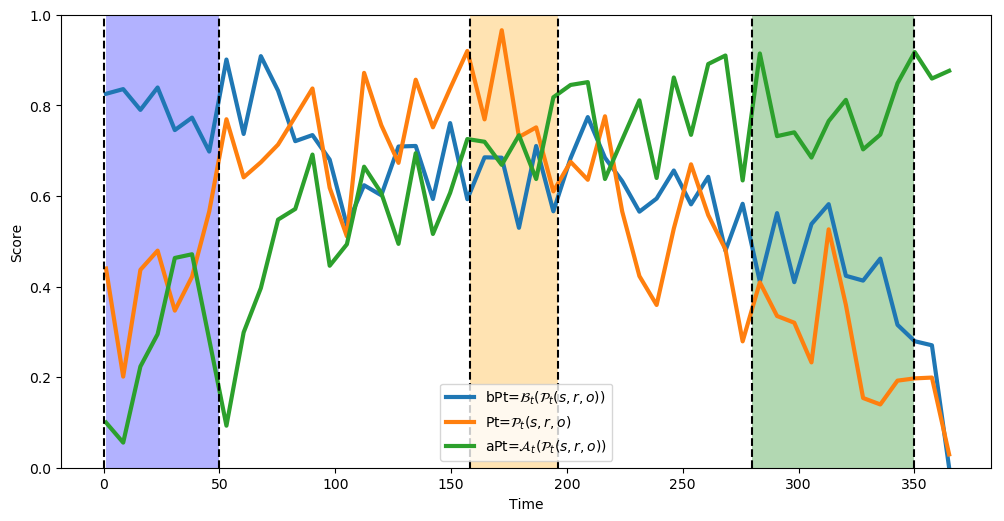

In [182]:
draw(152)

[1145, 224, 1022] {} {130}
Citizen (India)
Use unconventional violence
Chief Secretary Chandra
['2014-05-11']


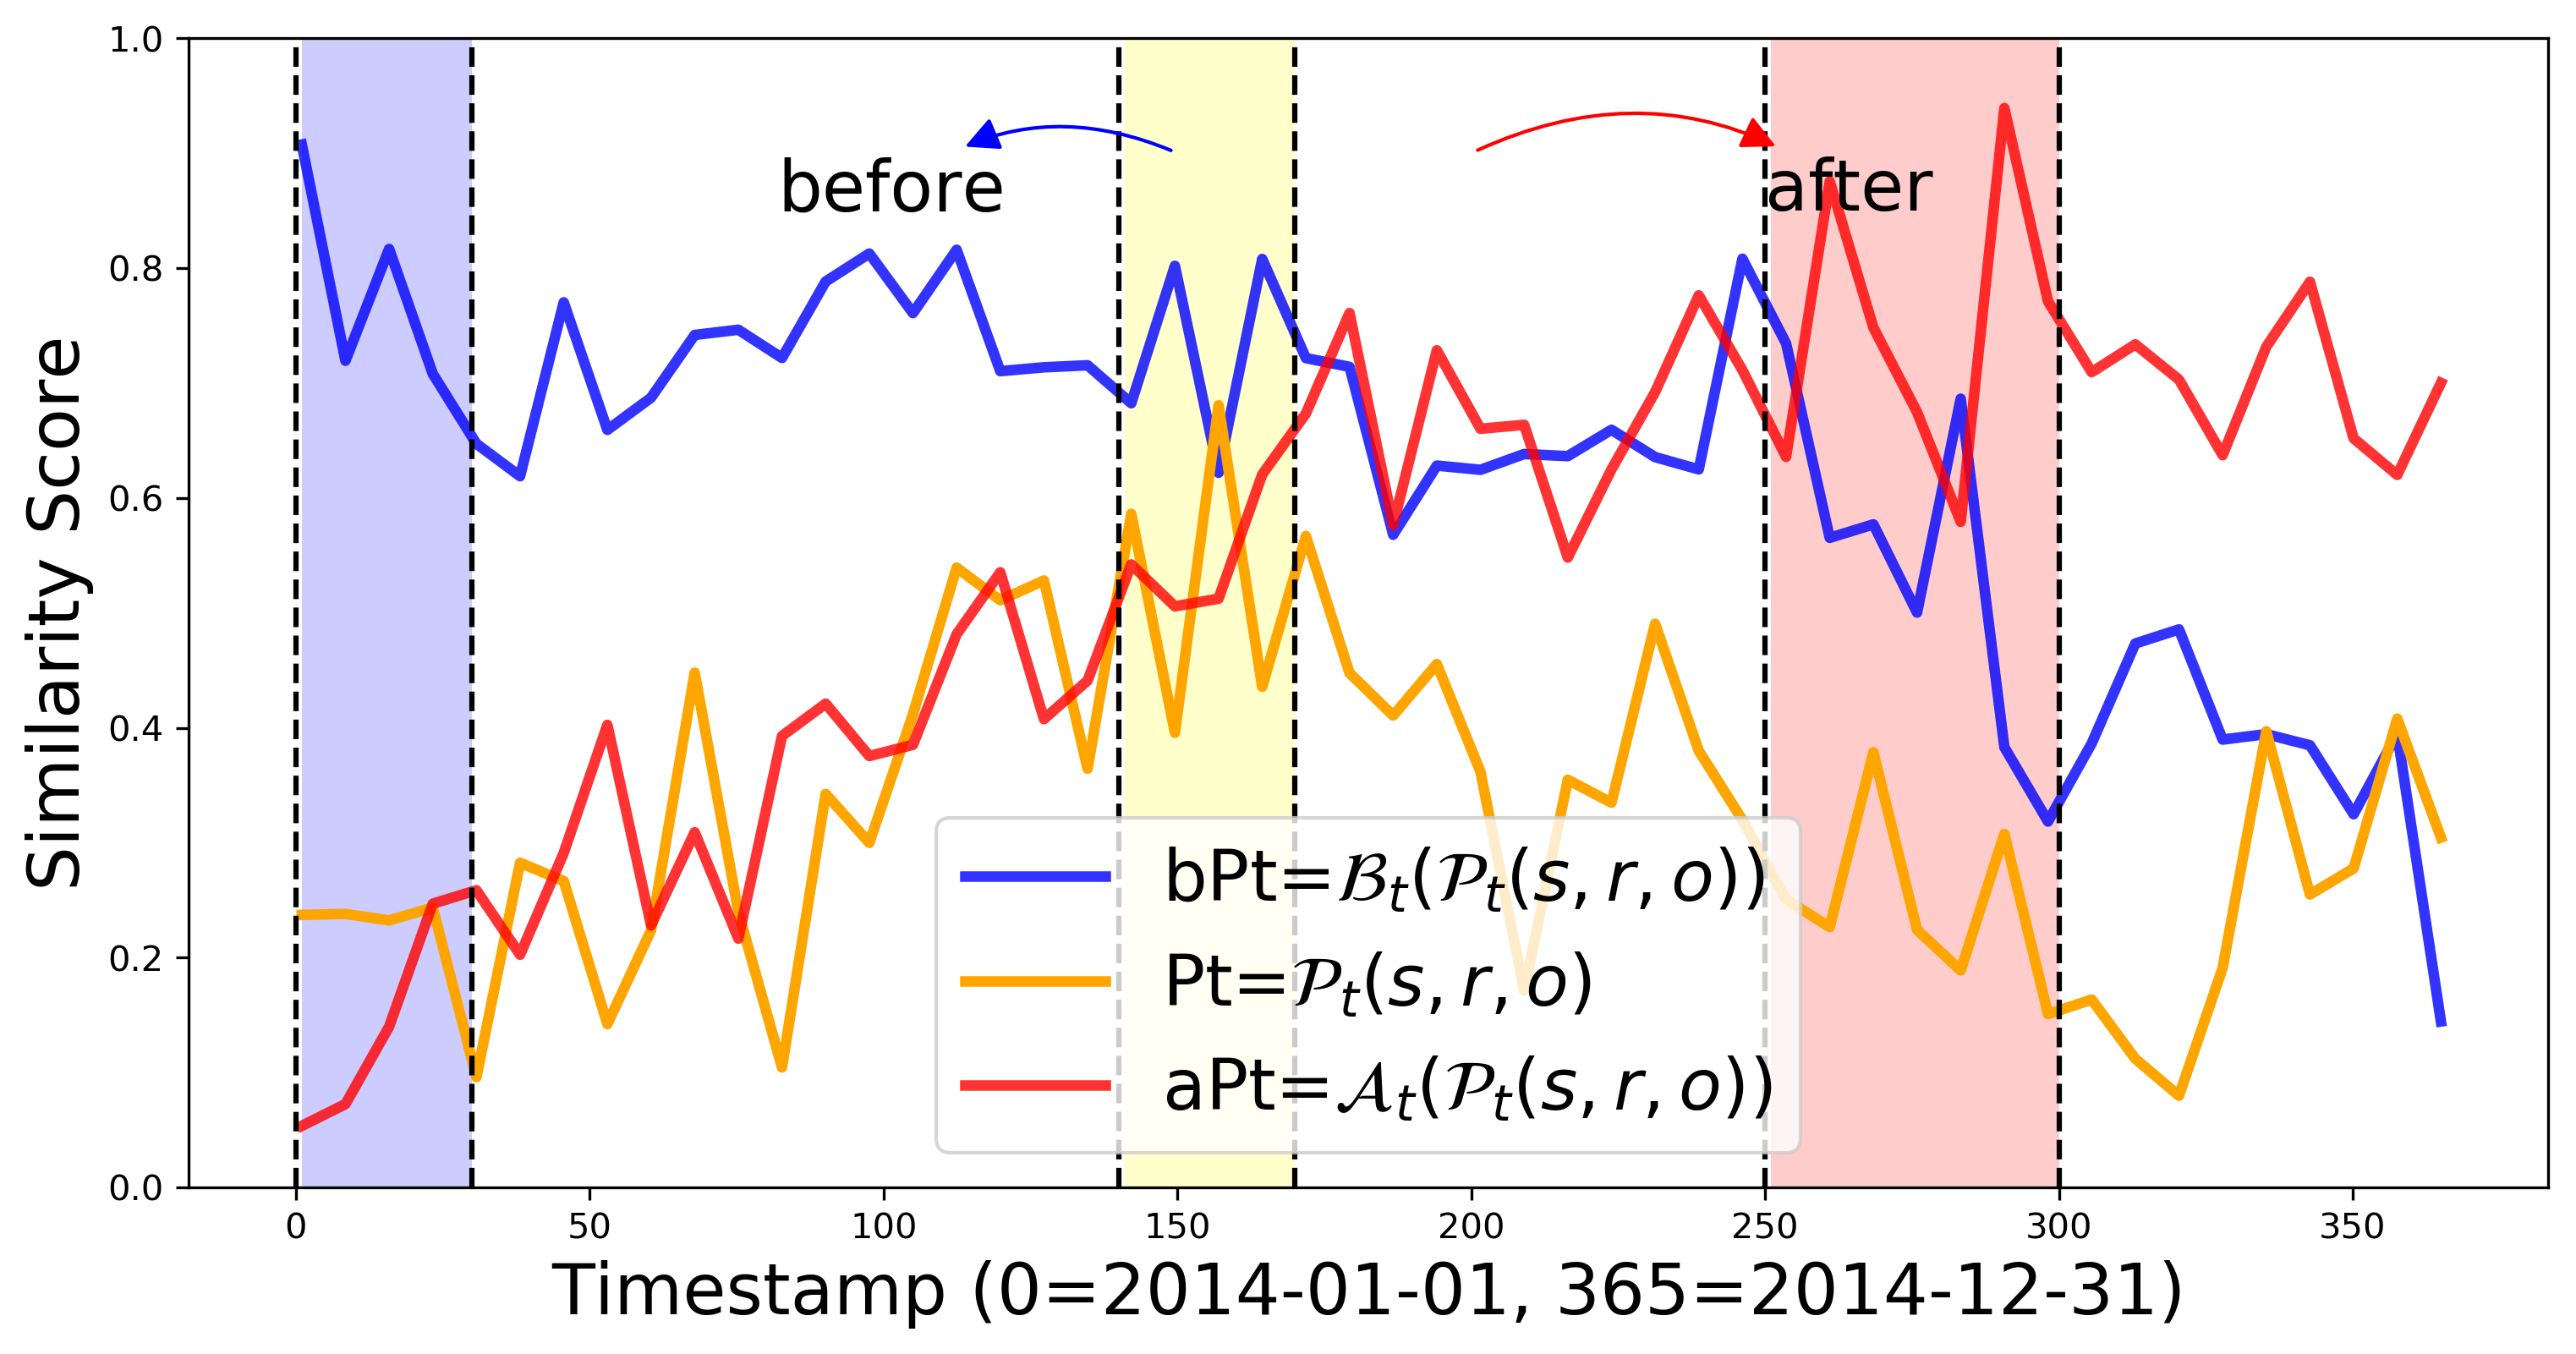

In [315]:
draw(165, 'before_after2.png', (0,30), (140, 170), (250, 300))

[1145, 224, 675] {} {277}
Citizen (India) Use unconventional violence Baldev Singh ['2014-10-05']


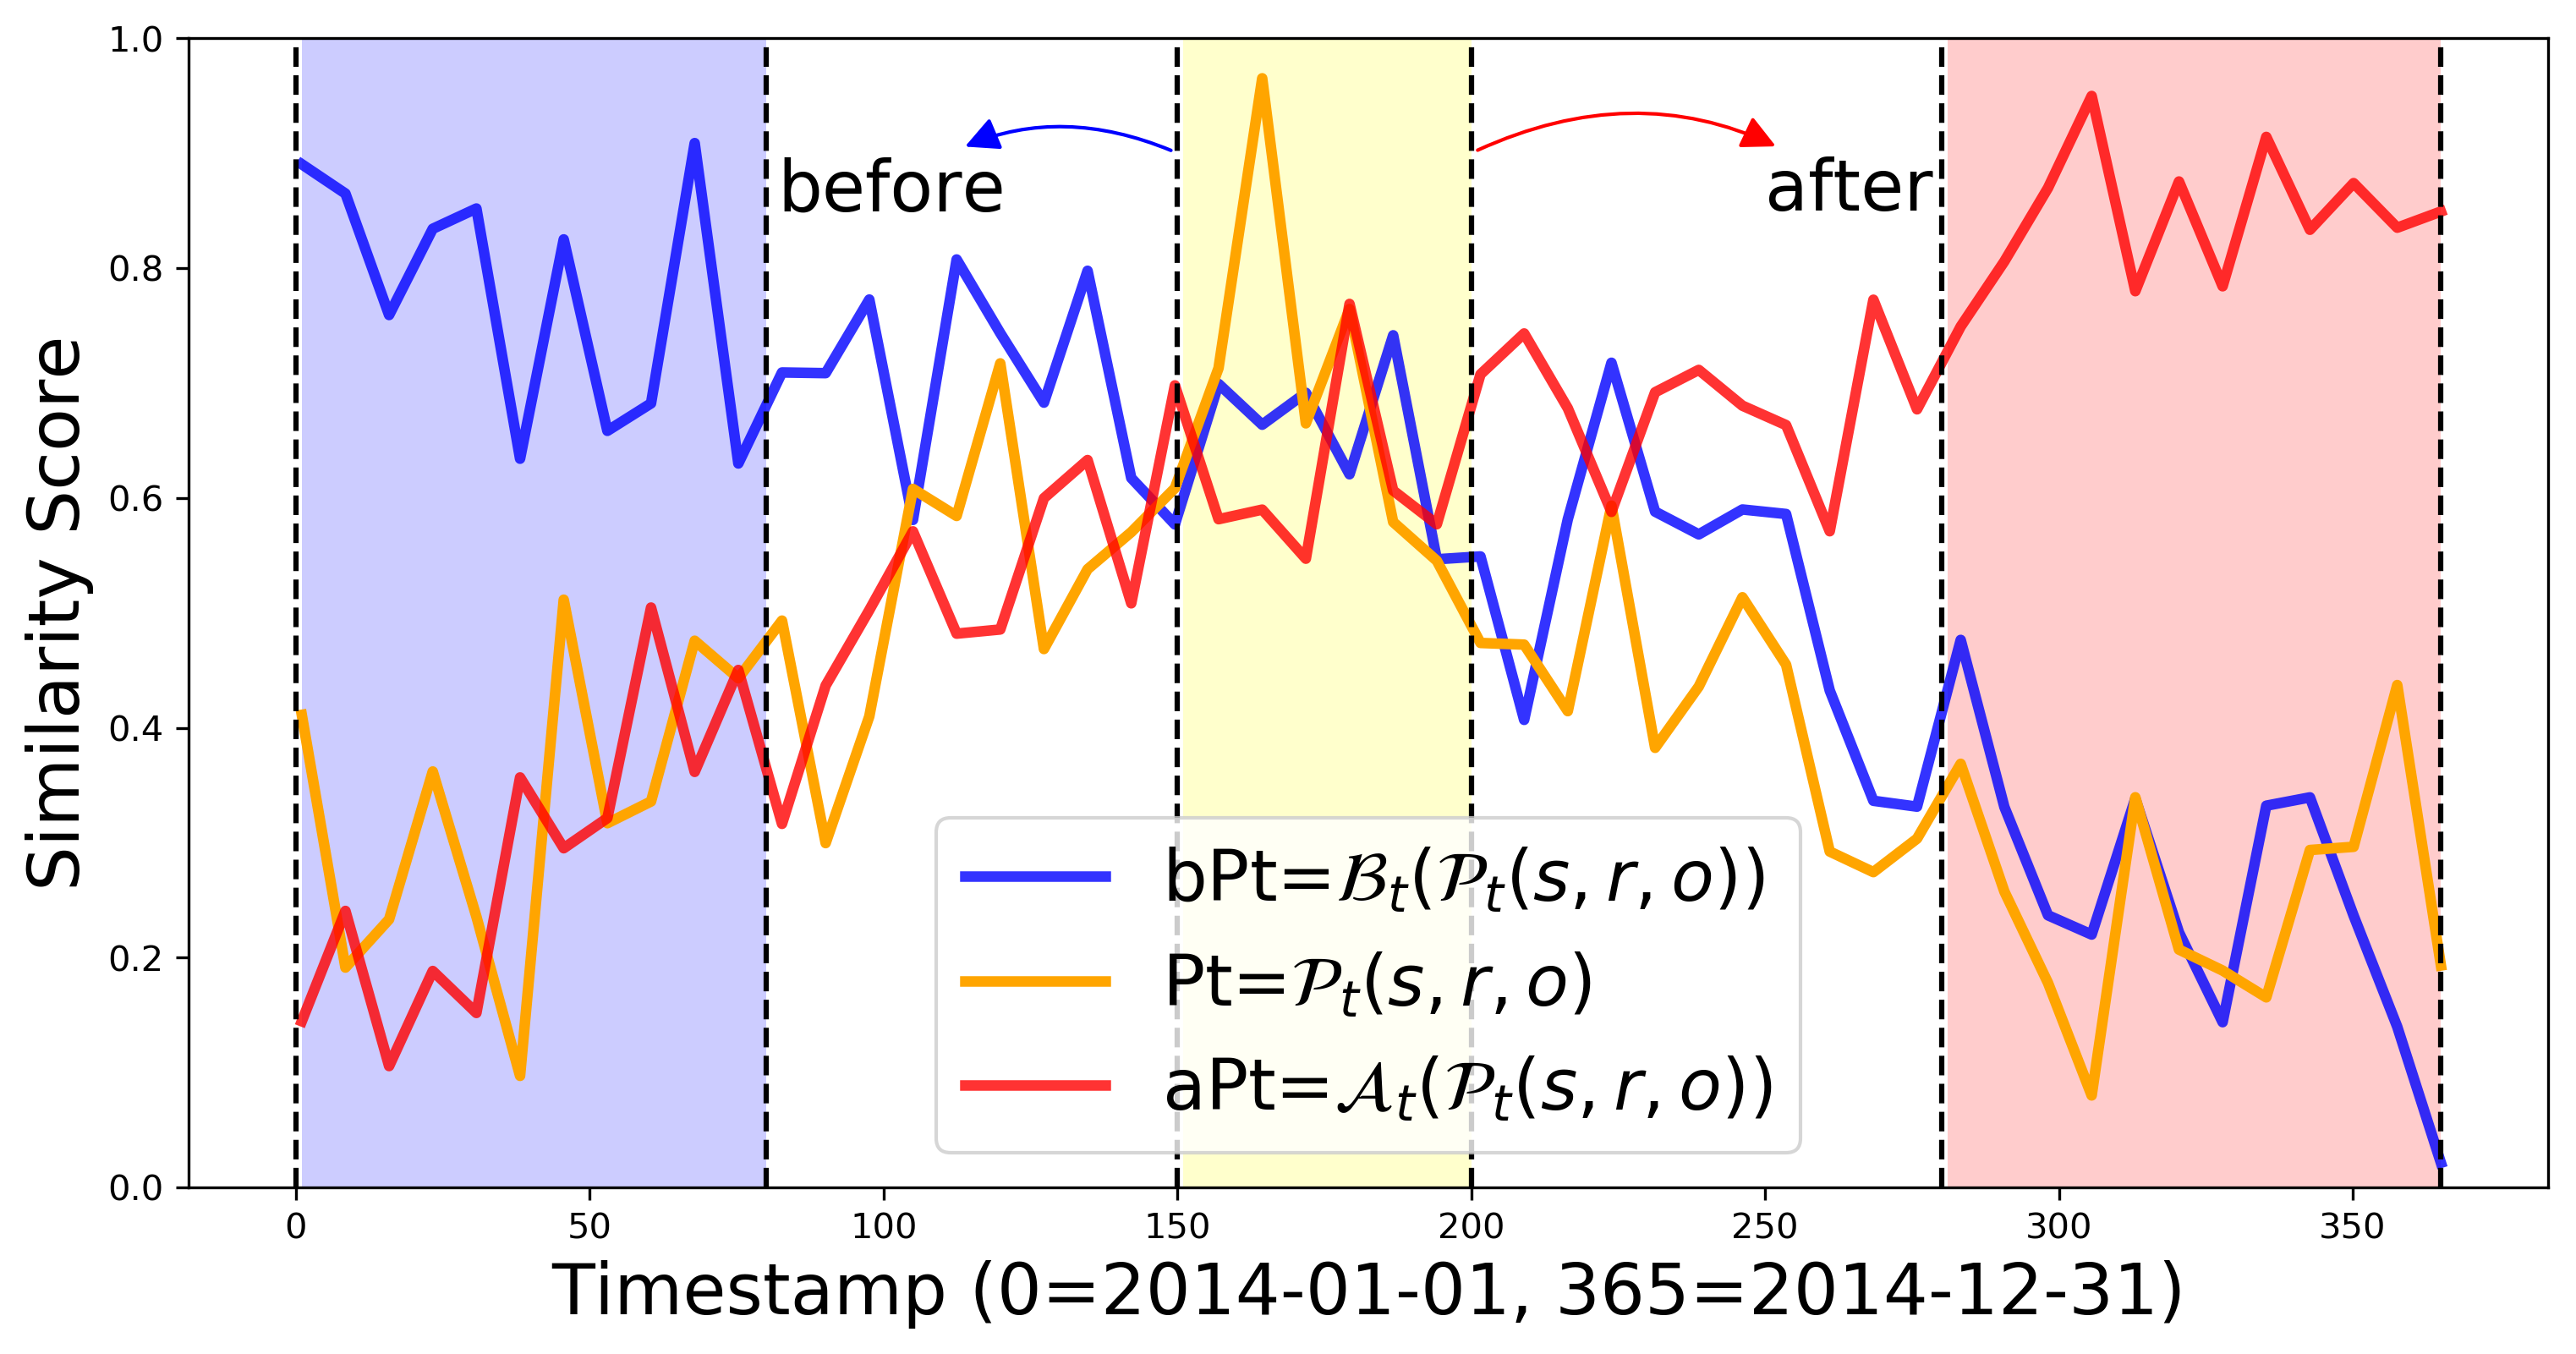

In [310]:
draw(166)

[1145, 224, 675] {} {277}
Citizen (India)
Use unconventional violence
Baldev Singh
['2014-10-05']


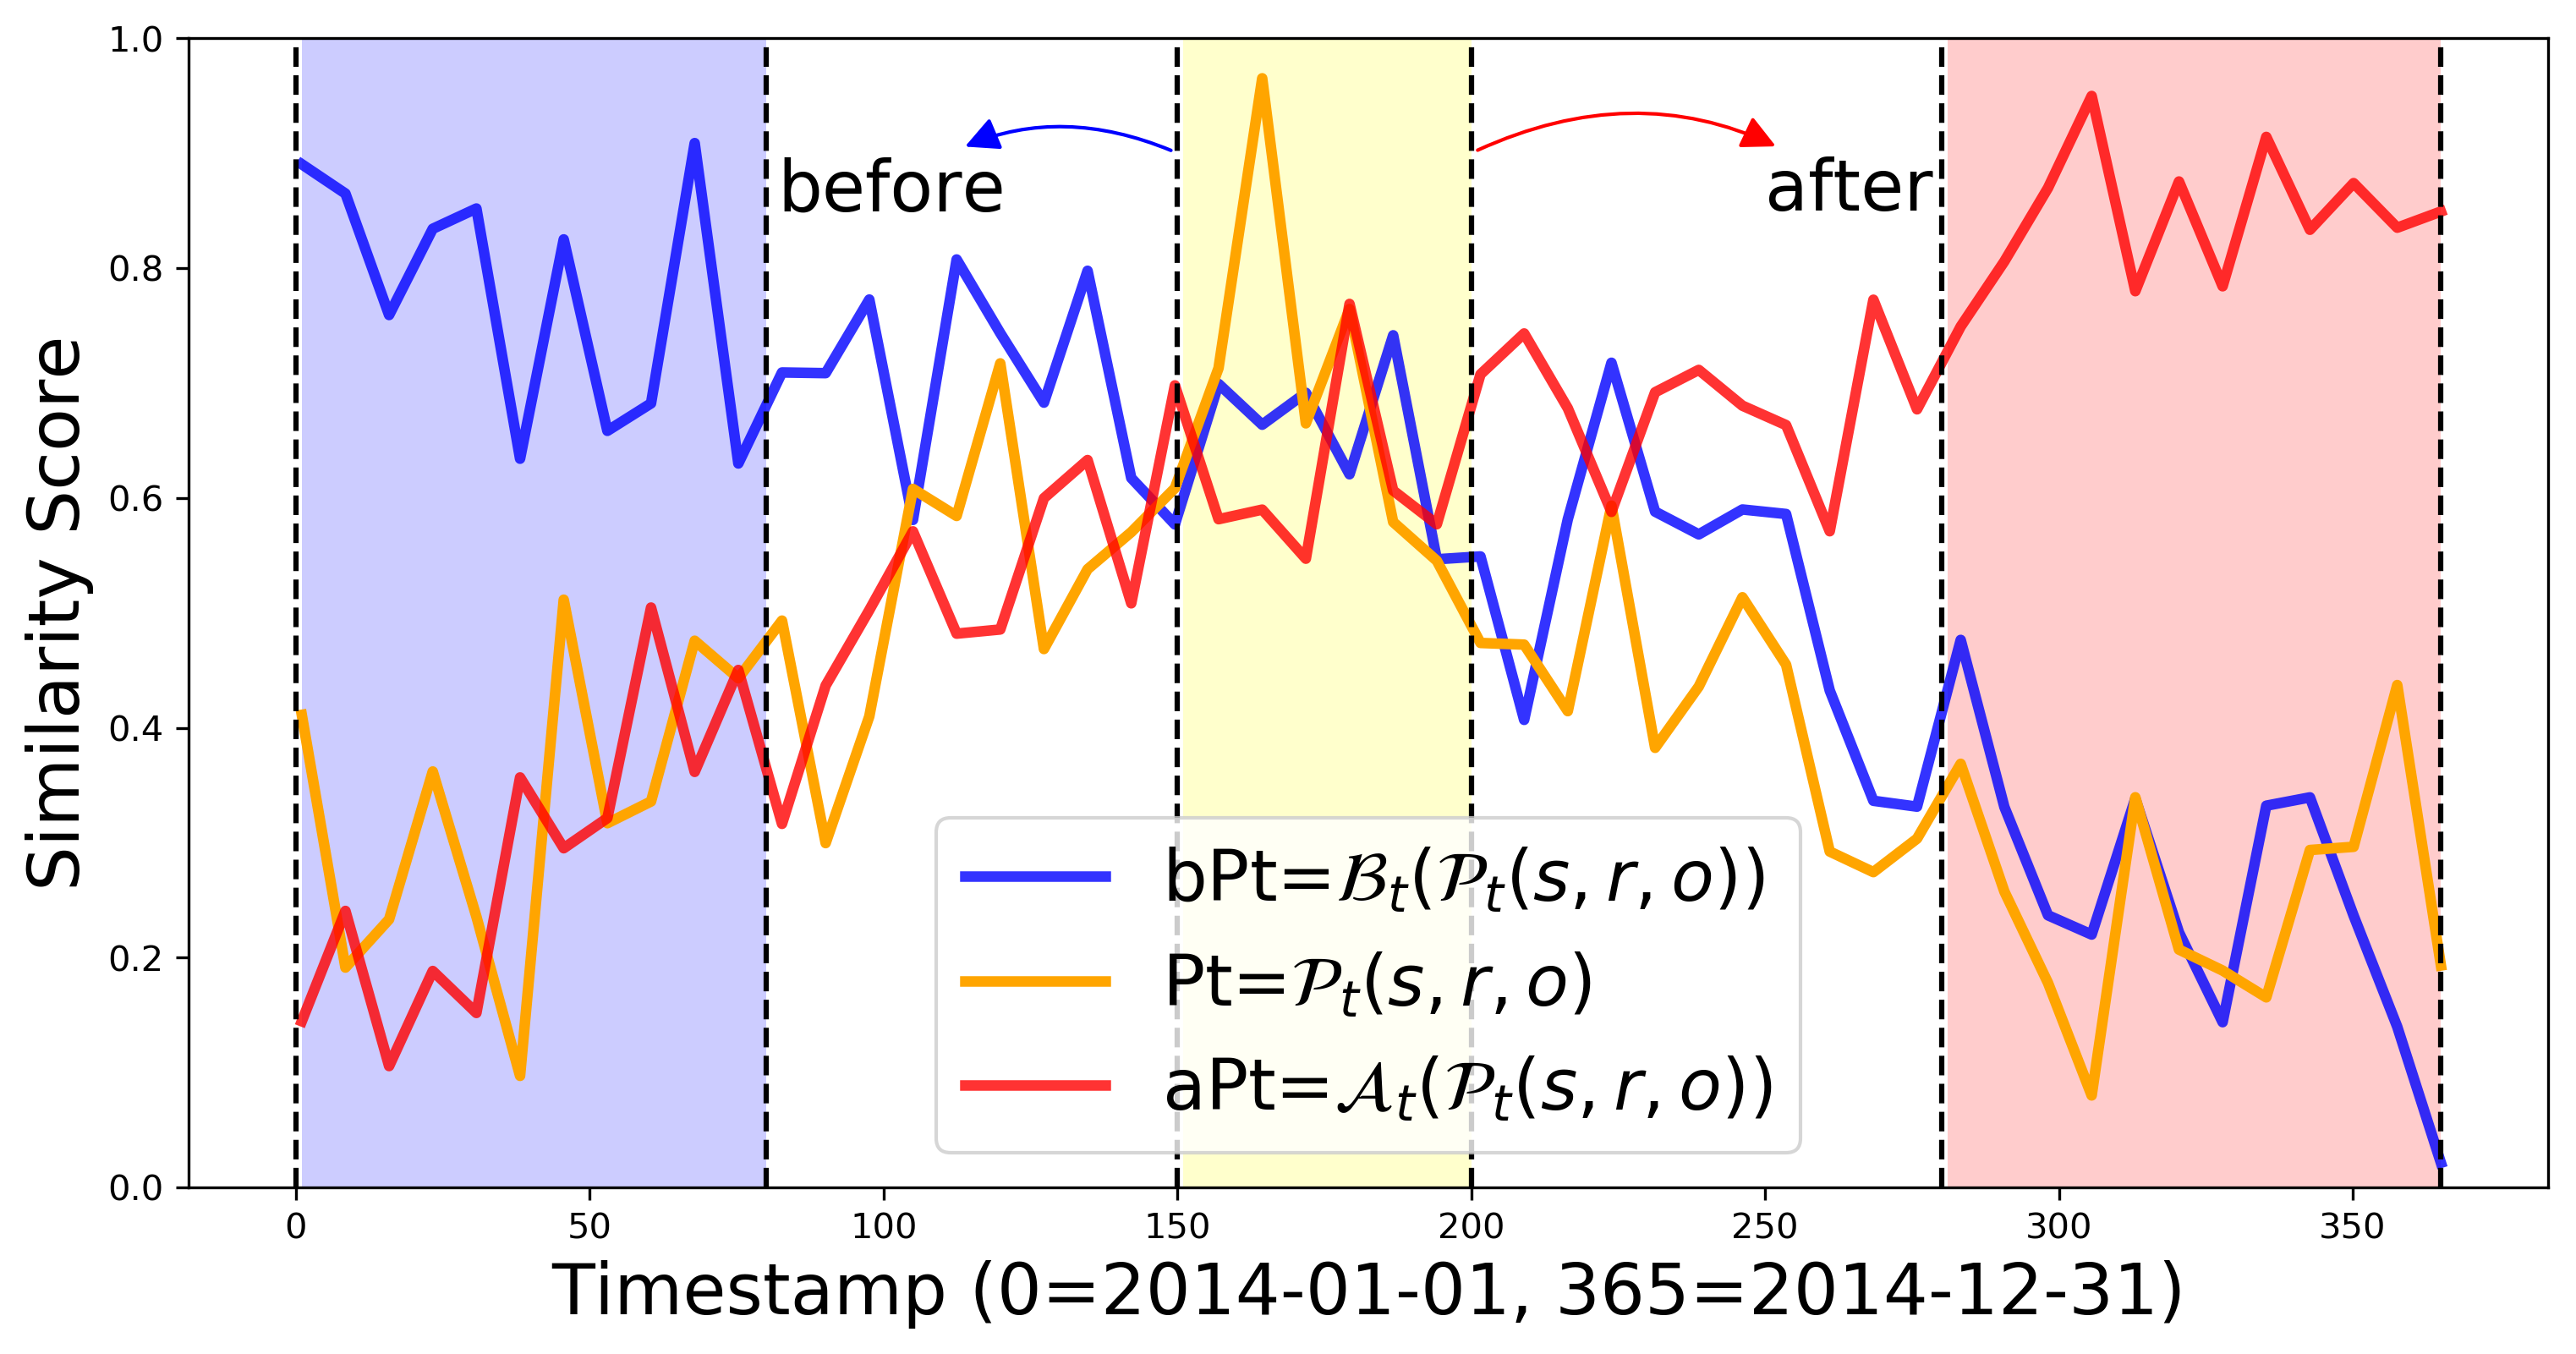

In [314]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline

def draw(id, filename=None, bPt_block=(0, 80), Pt_block=(150, 200), aPt_block=(280, 365)):
    query, easy_answer, hard_answer = use_for_draw[id]
    print(query, easy_answer, hard_answer)
    s, r, o = tuple(query)
    print(data.all_entities[s])
    print(data.all_relations[r])
    print(data.all_entities[o])
    print([data.all_timestamps[i] for i in hard_answer])
    grouped_query = {
        "TimeProjection": torch.LongTensor([
            query
        ]),
        "bPt": torch.LongTensor([
            query
        ]),
        "aPt": torch.LongTensor([
            query
        ])
    }
    grouped_candidate_answer = {
        "TimeProjection": torch.LongTensor(range(timestamp_count)),
        "bPt": torch.LongTensor(range(timestamp_count)),
        "aPt": torch.LongTensor(range(timestamp_count))
    }

    for query_name in grouped_query:
        grouped_query[query_name] = grouped_query[query_name].to(device)
        grouped_candidate_answer[query_name] = grouped_candidate_answer[query_name].to(device)

    grouped_score = model.grouped_predict(grouped_query, grouped_candidate_answer)

    Pt = grouped_score['TimeProjection'].squeeze()
    Pt_before = grouped_score['bPt'].squeeze()
    Pt_after = grouped_score['aPt'].squeeze()
#     Pt = -Pt
#     Pt_before = -Pt_before
#     Pt_after = -Pt_after
    Pt = Pt.cpu().detach().numpy()
    Pt_before = Pt_before.cpu().detach().numpy()
    Pt_after = Pt_after.cpu().detach().numpy()
    Pt = normalization(Pt)
    Pt_before = normalization(Pt_before)
    Pt_after = normalization(Pt_after)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6), dpi=300)

    x = np.array(list(range(1,366)))
    y1 = Pt_before
    y2 = Pt
    y3 = Pt_after
    nx = np.linspace(x.min(),x.max(),50)
    ny1 = make_interp_spline(x,y1)(nx)
    ny2 = make_interp_spline(x,y2)(nx)
    ny3 = make_interp_spline(x,y3)(nx)

    ny1 = make_interp_spline(x,y1)(nx)
    ny2 = make_interp_spline(x,y2)(nx)
    ny3 = make_interp_spline(x,y3)(nx)

    plt.plot(nx, ny1, color='blue', alpha=0.8, linewidth=3)
    plt.plot(nx, ny2, color='orange', alpha=1, linewidth=3)
    plt.plot(nx, ny3, color='red', alpha=0.8, linewidth=3)

    plt.axvline(bPt_block[0], color='black', linestyle ="--",)
    plt.axvline(bPt_block[1], color='black', linestyle ="--",)
    plt.fill_between(x[bPt_block[0]:bPt_block[1]], 0, 1, facecolor='blue', alpha=0.2)

    plt.axvline(Pt_block[0], color='black', linestyle ="--",)
    plt.axvline(Pt_block[1], color='black', linestyle ="--",)
    plt.fill_between(x[Pt_block[0]:Pt_block[1]], 0, 1, facecolor='yellow', alpha=0.2)

    plt.axvline(aPt_block[0], color='black', linestyle ="--",)
    plt.axvline(aPt_block[1], color='black', linestyle ="--",)
    plt.fill_between(x[aPt_block[0]:aPt_block[1]], 0, 1, facecolor='red', alpha=0.2)

    plt.legend(['bPt=$\mathcal{B}_t(\mathcal{P}_t(s,r,o))$', 'Pt=$\mathcal{P}_t(s,r,o)$', 'aPt=$\mathcal{A}_t(\mathcal{P}_t(s,r,o))$'], fontsize=20)  # 设置折线名称
    plt.xlabel('Timestamp (0=2014-01-01, 365=2014-12-31)', fontsize=20)
    plt.ylabel('Similarity Score', fontsize=20)
    # plt.xlim((0, 365))
    plt.ylim((0, 1))
    
#     plt.arrow(0.1,0.4,40,0.4,width=0.2)
#     plt.annotate('20104 listings', xy=(50, 0.8),
#             xytext=("Bronx", 16), 
#             va='center', 
#             ha='center',
#             arrowprops={'arrowstyle': '-|>', 'connectionstyle': 'arc3,rad=0.3'})
    plt.annotate("before", xy=(150, 0.9), xytext=(82, 0.85), fontsize=20, arrowprops={"arrowstyle":"<|-", "color":"blue", 'connectionstyle': 'arc3,rad=-0.3'})
    plt.annotate("after", xy=(200, 0.9), xytext=(250, 0.85), fontsize=20, arrowprops={"arrowstyle":"<|-", "color":"red", 'connectionstyle': 'arc3,rad=0.3'})
    if filename is None:
        filename = 'before_after.png'
    plt.savefig(filename, transparent=True, bbox_inches='tight')
    plt.show()
draw(166)

In [282]:
data.load_cache(["all_entities", "all_relations", "all_timestamps"])

In [286]:
q, easy_answer, hard_answer = use_for_draw[166]
s, r, o = tuple(q)
data.all_entities[s], data.all_relations[r], data.all_entities[o], [data.all_timestamps[i] for i in hard_answer]

('Citizen (India)',
 'Use unconventional violence',
 'Baldev Singh',
 ['2014-10-05'])

In [284]:
use_for_draw[166]

([1145, 224, 675], {}, {277})

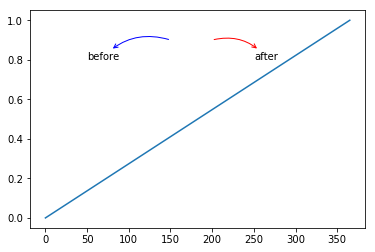

In [227]:
fig, ax = plt.subplots()
ax.plot([0, 365],[0, 1])
ax.annotate("before", xy=(150, 0.9), xytext=(50, 0.8), arrowprops={"arrowstyle":"<-", "color":"blue", 'connectionstyle': 'arc3,rad=-0.3'})
ax.annotate("after", xy=(200, 0.9), xytext=(250, 0.8), arrowprops={"arrowstyle":"<-", "color":"red", 'connectionstyle': 'arc3,rad=0.3'})
plt.show()

In [302]:
def draw_new(x, y, x_label, best_x):
    plt.figure(figsize=(4, 3), dpi=100)
    plt.plot(x, y, linewidth=1)
    plt.axvline(best_x, color='black', linestyle ="--",)
    plt.xlabel(x_label)
    plt.ylabel('MRR')
    plt.legend(["ICEWS14"])

In [300]:
gamma = [5,10, 15, 20, 25, 30, 40]
gamma_hrr = [31.16, 34.69, 35.14, 34.83, 34.73, 34.5, 33.59]
dim = [300, 400, 500, 600, 700, 800, 900, 1000]
dim_hrr = [34.5, 35.71, 35.94, 36.58, 36.94, 36.96, 36.57, 35.86]

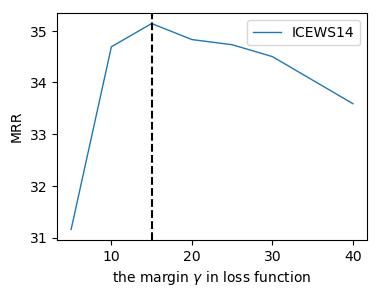

In [303]:
draw_new(gamma, gamma_hrr, 'the margin $\gamma$ in loss function', 15)

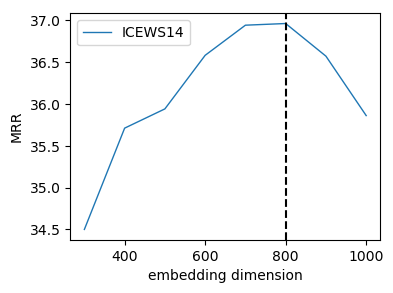

In [304]:
draw_new(dim, dim_hrr, 'embedding dimension', 800)